# Paper: "Skills to not fall behind in school"

**Author**: Felipe Maia Polo (felipemaiapolo@gmail.com)

**Abstract**: Many recent studies emphasize how important the role of cognitive and social-emotional skills canbe in determining people’s quality of life. Although skills are of great importance in many aspects,in this paper we will focus our efforts to better understand the relationship between several types ofskills with academic progress delay. Our dataset contains the same students in 2012 and 2017, andwe consider that there was a academic progress delay for a specific student if he/she progressed lessthan expected in school grades. Our methodology primarily includes the use of a Bayesian logisticregression model and our results suggest that both cognitive and social-emotional skills may impactthe conditional probability of falling behind in school, and the magnitude of the impact between thetwo types of skills can be comparable.

**Keywords**: Education · Bayes · Progress · Skills

# Setting up

Calling packages we will use:

In [2]:
library(rstanarm)
library(BART)
library(pROC)
library(parallel)
library(dummies)
library(plyr)  
library(iml)
library(ggplot2)
library(bayesplot)
library(grid)
library(gridExtra)
library(stargazer)
library(TeachingDemos)
library(rstan)
library(ranger)   # a c++ implementation of random forest 

Checking the number of CPU cores available:

In [3]:
detectCores(all.tests = FALSE, logical = TRUE)

[1] 4

# Loading the dataset and making main adjusts

Loading the data:

In [4]:
data<-read.table("/home/felipe/Desktop/Paper Bayesiana/Bases/bayesian_paper.csv", 
                 sep=";", dec=".", header=T)

data[1:3,]

id,grade_2012,grade_2017,follow_up,month,year,school_2012,ethinicity,gender,failed_before_2012,⋯,alt_2012,anx_2012,ass_2012,cmp_2012,dep_2012,ids_2012,ord_2012,sfd_2012,lang_2012,math_2012
3154,5,11,1,3,1999,municipal,indigena,mulher,sim,⋯,-1.086957,0.05797101,-0.1652174,-0.2753623,-1.826087,0.2956522,-1.826087,-0.8347826,55.80549144,20.0548289
1597,4,NA,0,NA,NA,municipal,preta,homem,sim,⋯,NA,NA,NA,NA,NA,NA,NA,NA,0.08313525,0.8041452
4824,5,10,1,12,2001,municipal,parda,mulher,nao,⋯,0.180000,0.50000000,0.5280000,0.8800000,-0.360000,-0.3840000,0.640000,0.5000000,65.06753110,52.0295819


Keeping only those students who were in 5th and 6th grades in 2012 (dropping 4th graders):

In [5]:
data<-subset(data, grade_2012!=4)

Creating variable which tells us in which semester the student was born:

In [6]:
data$semester <- ifelse(is.na(data$month), NA,
                 ifelse(data$month<=6, 1, 2))     

Creating variable 'white' (ethnicity):

In [7]:
data$white <- ifelse(is.na(data$ethinicity), NA,
              ifelse(data$ethinicity=='branca', 1,0))

Creating variable 'male' (gender):

In [8]:
data$male <- ifelse(is.na(data$gender), NA,
            ifelse(data$gender=='homem',1,0))

Creating variable 'failed_before_2012' which tells us if a student has failed in school before 2012:

In [9]:
data$failed_before_2012 <- ifelse(is.na(data$failed_before_2012), NA,
                           ifelse(data$failed_before_2012=='sim',1,0))

Creating variable 'pre_k' which tells us if a student has gone to Pre-Kindergarten:

In [10]:
data$pre_k <- ifelse(is.na(data$pre_k_pub) | is.na(data$pre_k_priv), NA,
              ifelse(data$pre_k_pub=='sim', 1,
              ifelse(data$pre_k_priv=='sim', 1,0)))

Creating variable 'kinder' which tells us if a student has gone to Kindergarten:

In [11]:
data$kinder <- ifelse(is.na(data$kinder_pub) | is.na(data$kinder_priv), NA,
               ifelse(data$kinder_pub=='sim', 1,
               ifelse(data$kinder_priv=='sim', 1,0)))

Creating variable 'attrition':

In [12]:
data$attrition <- 0^data$follow_up

Creating our target variable 'behind':

In [13]:
data$behind <- ifelse(is.na(data$grade_2012) | is.na(data$grade_2017), NA,
               ifelse(data$grade_2012==4 & data$grade_2017>=9, 0,
               ifelse(data$grade_2012==5 & data$grade_2017>=10, 0,
               ifelse(data$grade_2012==6 & data$grade_2017>=11, 0, 1))))

Descriptive stats for the target variable:

In [14]:
summary(data['behind'])

     behind      
 Min.   :0.0000  
 1st Qu.:0.0000  
 Median :0.0000  
 Mean   :0.1361  
 3rd Qu.:0.0000  
 Max.   :1.0000  
 NA's   :1203    

Checking available variables out:

In [15]:
names(data)
dim(data)

[1] "id"                 "grade_2012"         "grade_2017"        
 [4] "follow_up"          "month"              "year"              
 [7] "school_2012"        "ethinicity"         "gender"            
[10] "failed_before_2012" "mother_educ"        "pre_k_pub"         
[13] "pre_k_priv"         "kinder_pub"         "kinder_priv"       
[16] "act_2012"           "aes_2012"           "alt_2012"          
[19] "anx_2012"           "ass_2012"           "cmp_2012"          
[22] "dep_2012"           "ids_2012"           "ord_2012"          
[25] "sfd_2012"           "lang_2012"          "math_2012"         
[28] "semester"           "white"              "male"              
[31] "pre_k"              "kinder"             "attrition"         
[34] "behind"

[1] 3223   34

Selecting variables:

In [16]:
vars <- c('grade_2012', 'year', 'semester', 'school_2012', 'white', 'male', 
          'failed_before_2012', 'mother_educ', 'pre_k', 'kinder',
          'lang_2012', 'math_2012', 
          'act_2012', 'aes_2012', 'alt_2012', 'anx_2012', 'ass_2012', 
          'cmp_2012', 'dep_2012', 'ids_2012', 'ord_2012', 'sfd_2012',
          'attrition', 'behind')

Creating a second dataset with selected variables:

In [17]:
data2 <- data[vars]
dim(data2)
table(data$grade_2012)

[1] 3223   24


   5    6 
1680 1543 

Creating a function which omit rows cointaining NAs in specified columns:

In [18]:
na.omit2 <- function(data, cols){
  completeVec <- complete.cases(data[, cols])
  return(data[completeVec, ])
}

Omitting rows with NAs in any columns but 'pre_k', 'kinder','behind':

In [19]:
data2 <- na.omit2(data2, setdiff(names(data2), c('pre_k', 'kinder','behind')))
dim(data2)
table(data2$grade_2012)

[1] 2698   24


   5    6 
1420 1278 

Checking out percetage of remaining students:

In [20]:
2698/3223
1420/1680
1278/1543

[1] 0.8371083

[1] 0.8452381

[1] 0.8282566

# Attrition Analysis

Mother's education

In [21]:
var<-'mother_educ'

z0<-sum(tapply(data2[[var]], data2$attrition, summary)[['0']])
z1<-sum(tapply(data2[[var]], data2$attrition, summary)[['1']])

dist0<-tapply(data2[[var]], data2$attrition, summary)[['0']]/z0
dist1<-tapply(data2[[var]], data2$attrition, summary)[['1']]/z1

table<-cbind(dist1,dist0,dist1-dist0)[c('nao_sabe','nunca_estudou','ef1','ef2','em','superior'),]
table<-round(table,2)
table<-apply(table, 2, gsub, patt=",", replace=".")

colnames(table)<-c('Attrition','Non-Attrition','Diff.')
rownames(table)<-c('Unknown','Non-educated','Elementary','Middle','High','College')

table
stargazer(table)

,Attrition,Non-Attrition,Diff.
Unknown,0.06,0.01,0.05
Non-educated,0.14,0.15,-0.01
Elementary,0.34,0.29,0.05
Middle,0.19,0.22,-0.03
High,0.19,0.26,-0.07
College,0.08,0.07,0.01



% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: dom, jan 05, 2020 - 22:16:08
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} cccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Attrition & Non-Attrition & Diff. \\ 
\hline \\[-1.8ex] 
Unknown & 0.06 & 0.01 & 0.05 \\ 
Non-educated & 0.14 & 0.15 & -0.01 \\ 
Elementary & 0.34 & 0.29 & 0.05 \\ 
Middle & 0.19 & 0.22 & -0.03 \\ 
High & 0.19 & 0.26 & -0.07 \\ 
College & 0.08 & 0.07 & 0.01 \\ 
\hline \\[-1.8ex] 
\end{tabular} 
\end{table} 


School

In [22]:
var<-'school_2012'

z0<-sum(tapply(data2[[var]], data2$attrition, summary)[['0']])
z1<-sum(tapply(data2[[var]], data2$attrition, summary)[['1']])

dist0<-tapply(data2[[var]], data2$attrition, summary)[['0']]/z0
dist1<-tapply(data2[[var]], data2$attrition, summary)[['1']]/z1

table<-cbind(dist1,dist0,dist1-dist0)[c('estadual','municipal','privada'),]
table<-round(table,2)
table<-apply(table, 2, gsub, patt=",", replace=".")

colnames(table)<-c('Attrition','Non-Attrition','Diff.')
rownames(table)<-c('State','Municipal','Private')

table
stargazer(table)

,Attrition,Non-Attrition,Diff.
State,0.31,0.27,0.04
Municipal,0.62,0.63,-0.01
Private,0.08,0.1,-0.02



% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: dom, jan 05, 2020 - 22:16:09
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} cccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Attrition & Non-Attrition & Diff. \\ 
\hline \\[-1.8ex] 
State & 0.31 & 0.27 & 0.04 \\ 
Municipal & 0.62 & 0.63 & -0.01 \\ 
Private & 0.08 & 0.1 & -0.02 \\ 
\hline \\[-1.8ex] 
\end{tabular} 
\end{table} 


Others

In [23]:
table<-c()

for(var in c('white', 'male', 'failed_before_2012')){
    dist0<-tapply(data2[[var]], data2$attrition, mean)[['0']]
    dist1<-tapply(data2[[var]], data2$attrition, mean)[['1']]

    table<-rbind(table, cbind(dist1,dist0,dist1-dist0))
}

table<-round(table,2)
table<-apply(table, 2, gsub, patt=",", replace=".")

colnames(table)<-c('Attrition','Non-Attrition','Diff.')
rownames(table)<-c('White','Male','Failed before 2012')

table
stargazer(table)

,Attrition,Non-Attrition,Diff.
White,0.36,0.4,-0.04
Male,0.55,0.48,0.07
Failed before 2012,0.47,0.25,0.23



% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: dom, jan 05, 2020 - 22:16:10
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} cccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Attrition & Non-Attrition & Diff. \\ 
\hline \\[-1.8ex] 
White & 0.36 & 0.4 & -0.04 \\ 
Male & 0.55 & 0.48 & 0.07 \\ 
Failed before 2012 & 0.47 & 0.25 & 0.23 \\ 
\hline \\[-1.8ex] 
\end{tabular} 
\end{table} 


Socioemotional skills and grades:

In [24]:
skills<-c('lang_2012', 'math_2012', 
          'act_2012', 'aes_2012', 'alt_2012', 'anx_2012', 'ass_2012', 
          'cmp_2012', 'dep_2012', 'ids_2012', 'ord_2012', 'sfd_2012')

data2[,skills]<-scale(data2[,skills])

In [25]:
table<-c()

for(var in skills){
    dist0<-tapply(data2[[var]], data2$attrition, mean)[['0']]
    dist1<-tapply(data2[[var]], data2$attrition, mean)[['1']]

    table<-rbind(table, cbind(dist1,dist0,dist1-dist0))
}

table<-round(table,2)
table<-apply(table, 2, gsub, patt=",", replace=".")

colnames(table)<-c('Attrition','Non-Attrition','Diff.')
rownames(table)<- c('Language 2012', 'Mathematics 2012', 
                       "Activity", "Aesthetics", "Altruism", "Anxiety", "Assertiveness", 
                       "Compliance", "Depression", "Ideas", "Order", "Self-Discipline")

table
stargazer(table)

,Attrition,Non-Attrition,Diff.
Language 2012,-0.27,0.14,-0.41
Mathematics 2012,-0.23,0.12,-0.35
Activity,-0.08,0.04,-0.12
Aesthetics,0.1,-0.05,0.15
Altruism,0.04,-0.02,0.07
Anxiety,0,0,0
Assertiveness,0.05,-0.03,0.08
Compliance,-0.04,0.02,-0.07
Depression,0.07,-0.04,0.1
Ideas,-0.04,0.02,-0.05



% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: dom, jan 05, 2020 - 22:16:11
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} cccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Attrition & Non-Attrition & Diff. \\ 
\hline \\[-1.8ex] 
Language 2012 & -0.27 & 0.14 & -0.41 \\ 
Mathematics 2012 & -0.23 & 0.12 & -0.35 \\ 
Activity & -0.08 & 0.04 & -0.12 \\ 
Aesthetics & 0.1 & -0.05 & 0.15 \\ 
Altruism & 0.04 & -0.02 & 0.07 \\ 
Anxiety & 0 & 0 & 0 \\ 
Assertiveness & 0.05 & -0.03 & 0.08 \\ 
Compliance & -0.04 & 0.02 & -0.07 \\ 
Depression & 0.07 & -0.04 & 0.1 \\ 
Ideas & -0.04 & 0.02 & -0.05 \\ 
Order & 0.07 & -0.04 & 0.11 \\ 
Self-Discipline & 0.03 & -0.02 & 0.05 \\ 
\hline \\[-1.8ex] 
\end{tabular} 
\end{table} 


# Motivation

Creating a temporary dataset

In [26]:
#temp_data2<-data2

Getting rid of rows with NAs in at least one column:

In [26]:
data2=na.omit(data2)
dim(data2)

table(data2$grade_2012)

[1] 1780   24


  5   6 
959 821 

Remaining students:

In [27]:
1780/2698
959/1420 
821/1278

[1] 0.659748

[1] 0.6753521

[1] 0.64241

#### Descriptive stats:

Mother's educ:

In [28]:
var<-'mother_educ'

z<-sum(summary(data2[[var]]))
table<-summary(data2[[var]])/z
table<-as.matrix(table)

table<-as.data.frame(table[c('nao_sabe','nunca_estudou','ef1','ef2','em','superior'),])
table<-round(table,2)
table<-apply(table, 2, gsub, patt=",", replace=".")

colnames(table)<-c('Proportion')
rownames(table)<-c('Unknown','Non-educated','Elementary','Middle','High','College')

table
stargazer(table)

,Proportion
Unknown,0.01
Non-educated,0.15
Elementary,0.29
Middle,0.22
High,0.26
College,0.07



% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: dom, jan 05, 2020 - 22:16:26
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} cc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Proportion \\ 
\hline \\[-1.8ex] 
Unknown & 0.01 \\ 
Non-educated & 0.15 \\ 
Elementary & 0.29 \\ 
Middle & 0.22 \\ 
High & 0.26 \\ 
College & 0.07 \\ 
\hline \\[-1.8ex] 
\end{tabular} 
\end{table} 


School:

In [29]:
var<-'school_2012'

z<-sum(summary(data2[[var]]))
table<-summary(data2[[var]])/z
table<-as.matrix(table)

table<-as.data.frame(table[c('estadual','municipal','privada'),])
table<-round(table,2)
table<-apply(table, 2, gsub, patt=",", replace=".")

colnames(table)<-c('Proportion')
rownames(table)<-c('State','Municipal','Private')

table
stargazer(table)

,Proportion
State,0.27
Municipal,0.63
Private,0.1



% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: dom, jan 05, 2020 - 22:16:27
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} cc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Proportion \\ 
\hline \\[-1.8ex] 
State & 0.27 \\ 
Municipal & 0.63 \\ 
Private & 0.1 \\ 
\hline \\[-1.8ex] 
\end{tabular} 
\end{table} 


Others:

In [30]:
table<-c()

for(var in c('white', 'male', 'failed_before_2012','pre_k','kinder')){
    table<-rbind(table, mean(data2[[var]]))
}

table<-round(table,2)
table<-apply(table, 2, gsub, patt=",", replace=".")

colnames(table)<-c('Proportion')
rownames(table)<-c('White','Male','Failed before 2012','Pre-K','Kinder')

table
stargazer(table)

,Proportion
White,0.4
Male,0.48
Failed before 2012,0.25
Pre-K,0.48
Kinder,0.86



% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: dom, jan 05, 2020 - 22:16:27
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} cc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Proportion \\ 
\hline \\[-1.8ex] 
White & 0.4 \\ 
Male & 0.48 \\ 
Failed before 2012 & 0.25 \\ 
Pre-K & 0.48 \\ 
Kinder & 0.86 \\ 
\hline \\[-1.8ex] 
\end{tabular} 
\end{table} 


Skills variables. First we standardize skills variables:

In [31]:
skills_stand<-list()

for(s in skills){
    skills_stand[[s]]<-c(mean(data2[[s]]), sd(data2[[s]]))
    data2[[s]]<-(data2[[s]]-skills_stand[[s]][1])/skills_stand[[s]][2]
}

In [32]:
table<-c()

for(var in skills){
    table<-rbind(table, summary(data2[[var]]))
}

table<-round(table,2)
table<-apply(table, 2, gsub, patt=",", replace=".")

rownames(table)<- c('Language 2012', 'Mathematics 2012', 
                       "Activity", "Aesthetics", "Altruism", "Anxiety", "Assertiveness", 
                       "Compliance", "Depression", "Ideas", "Order", "Self-Discipline")

table
stargazer(table)

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.
Language 2012,-4.04,-0.47,0.11,0,0.73,1.82
Mathematics 2012,-3.34,-0.63,0.03,0,0.71,2.07
Activity,-3.5,-0.7,0.04,0,0.76,2.62
Aesthetics,-3.45,-0.64,-0.05,0,0.66,3.33
Altruism,-3.02,-0.7,-0.05,0,0.6,3.97
Anxiety,-3.87,-0.42,0.01,0,0.73,3.27
Assertiveness,-3.22,-0.62,-0.05,0,0.65,3.4
Compliance,-2.68,-0.69,-0.01,0,0.71,2.8
Depression,-2.45,-0.74,-0.16,0,0.57,5.5
Ideas,-4.09,-0.62,0,0,0.64,3.31



% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: dom, jan 05, 2020 - 22:16:29
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} ccccccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Min. & 1st Qu. & Median & Mean & 3rd Qu. & Max. \\ 
\hline \\[-1.8ex] 
Language 2012 & -4.04 & -0.47 & 0.11 & 0 & 0.73 & 1.82 \\ 
Mathematics 2012 & -3.34 & -0.63 & 0.03 & 0 & 0.71 & 2.07 \\ 
Activity & -3.5 & -0.7 & 0.04 & 0 & 0.76 & 2.62 \\ 
Aesthetics & -3.45 & -0.64 & -0.05 & 0 & 0.66 & 3.33 \\ 
Altruism & -3.02 & -0.7 & -0.05 & 0 & 0.6 & 3.97 \\ 
Anxiety & -3.87 & -0.42 & 0.01 & 0 & 0.73 & 3.27 \\ 
Assertiveness & -3.22 & -0.62 & -0.05 & 0 & 0.65 & 3.4 \\ 
Compliance & -2.68 & -0.69 & -0.01 & 0 & 0.71 & 2.8 \\ 
Depression & -2.45 & -0.74 & -0.16 & 0 & 0.57 & 5.5 \\ 
Ideas & -4.09 & -0.62 & 0 & 0 & 0.64 & 3.31 \\ 
Order & -2.51 & -0.74 & -0.15 & 0 & 0.64 & 4.37 \\ 
Self-Discipline & -3.

#### Conditional distribution of interest variables given 'behind':

In [33]:
table<-t(as.matrix(c(mean(data2$behind), 1-mean(data2$behind))))
table<-round(table,2)
table<-t(as.matrix(gsub(table, patt=",", replace=".")))

colnames(table)<-c('Behind','Not Behind')
rownames(table)<-c('Proportion')

Proportion of students who fell behind in school in the actual sample:

In [34]:
table
stargazer(table)

,Behind,Not Behind
Proportion,0.13,0.87



% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: dom, jan 05, 2020 - 22:16:34
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} ccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Behind & Not Behind \\ 
\hline \\[-1.8ex] 
Proportion & 0.13 & 0.87 \\ 
\hline \\[-1.8ex] 
\end{tabular} 
\end{table} 


Differences in skills:

In [35]:
table<-c()

for(var in skills){
    dist0<-tapply(data2[[var]], data2$behind, summary)[['0']][4]
    dist1<-tapply(data2[[var]], data2$behind, summary)[['1']][4]

    table<-rbind(table, cbind(dist1,dist0,dist1-dist0))
}

table<-round(table,2)
table<-apply(table, 2, gsub, patt=",", replace=".")

colnames(table)<-c('Behind','Not Behind','Diff')
rownames(table)<- c('Language 2012', 'Mathematics 2012', 
                       "Activity", "Aesthetics", "Altruism", "Anxiety", "Assertiveness", 
                       "Compliance", "Depression", "Ideas", "Order", "Self-Discipline")


table
stargazer(table)

,Behind,Not Behind,Diff
Language 2012,-0.52,0.08,-0.6
Mathematics 2012,-0.44,0.07,-0.51
Activity,-0.16,0.02,-0.18
Aesthetics,0.11,-0.02,0.12
Altruism,0.19,-0.03,0.22
Anxiety,-0.11,0.02,-0.13
Assertiveness,0.27,-0.04,0.31
Compliance,-0.03,0,-0.03
Depression,0.33,-0.05,0.38
Ideas,-0.03,0,-0.04



% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: dom, jan 05, 2020 - 22:16:35
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} cccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Behind & Not Behind & Diff \\ 
\hline \\[-1.8ex] 
Language 2012 & -0.52 & 0.08 & -0.6 \\ 
Mathematics 2012 & -0.44 & 0.07 & -0.51 \\ 
Activity & -0.16 & 0.02 & -0.18 \\ 
Aesthetics & 0.11 & -0.02 & 0.12 \\ 
Altruism & 0.19 & -0.03 & 0.22 \\ 
Anxiety & -0.11 & 0.02 & -0.13 \\ 
Assertiveness & 0.27 & -0.04 & 0.31 \\ 
Compliance & -0.03 & 0 & -0.03 \\ 
Depression & 0.33 & -0.05 & 0.38 \\ 
Ideas & -0.03 & 0 & -0.04 \\ 
Order & 0.16 & -0.02 & 0.19 \\ 
Self-Discipline & 0.05 & -0.01 & 0.05 \\ 
\hline \\[-1.8ex] 
\end{tabular} 
\end{table} 


# Logistic regression

Creating a dataset we will use to train our random forest model:

In [36]:
data_rf <- data2[,!(names(data2) %in% c('attrition'))]

Creating a new dataset for the logistic regression with the binarized variables:

In [37]:
data3 <- dummy.data.frame(data2, names = c('school_2012', 'mother_educ') , sep = ".")

Dropping 'omitted' categories and variable 'attrition':

In [38]:
drop <- c('mother_educ.nunca_estudou','school_2012.estadual','attrition') 

data3 <- data3[,!(names(data3) %in% drop)]

Setting up parameters to run stan model:

In [39]:
iter=251000
warmup=1000
thin=100
chains=4

#Posterior samples
(iter-warmup)/thin

[1] 2500

In [40]:
prior_scale<-1000
normal_prior <- normal(0, prior_scale)

In [42]:
start.time <- Sys.time()

fit <- stan_glm(behind ~ ., data = data3, 
                               family = binomial(link = "logit"), 
                               prior = normal_prior, prior_intercept = normal_prior,  
                               cores = 4, seed = 2, chains = chains,  
                               iter=iter, thin=thin, warmup=warmup)

end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 1.195004 hours

Saving the model:

In [44]:
save(fit, file="log_reg_normal.RData")

Loading the model

In [45]:
env <- environment()
load("log_reg_normal.RData", envir = env)
fit <- env$fit

names(fit)

[1] "coefficients"      "ses"               "fitted.values"    
 [4] "linear.predictors" "residuals"         "df.residual"      
 [7] "covmat"            "y"                 "model"            
[10] "data"              "family"            "offset"           
[13] "weights"           "prior.weights"     "contrasts"        
[16] "na.action"         "formula"           "terms"            
[19] "prior.info"        "algorithm"         "stan_summary"     
[22] "stanfit"           "rstan_version"     "call"             
[25] "stan_function"     "compute_mean_PPD"  "xlevels"

# Results

### Posterior analysis

In [46]:
posterior<-as.matrix(fit)
dim(posterior)

[1] 10000    28

#### Skills variables

In [47]:
#temp<-posterior[,skills]
#colnames(temp) <- c('Language 2012', 'Mathematics 2012', 
#                            "Activity", "Aesthetics", "Altruism", "Anxiety", "Assertiveness", 
#                            "Compliance", "Depression", "Ideas", "Order", "Self-Discipline")

#mcmc_intervals(temp, prob=.95, prob_outer = 0.99)

#dev.copy(png,'Plots/posterior_skills.png',width=700,height=700,res=150)
#dev.off()

In [49]:
posterior<-as.matrix(fit)
posterior_df<-as.data.frame(posterior)
table<-c()

for(var in skills){
    update<-emp.hpd(posterior_df[[var]])
    table<-rbind(table, update)
}

table<-round(table,2)
table<-apply(table, 2, gsub, patt=",", replace=".")

colnames(table)<-c('Lower Bound - HPD 95%','Upper Bound - HPD 95%')
rownames(table)<- c('Language 2012', 'Mathematics 2012', 
                       "Activity", "Aesthetics", "Altruism", "Anxiety", "Assertiveness", 
                       "Compliance", "Depression", "Ideas", "Order", "Self-Discipline")

table
stargazer(table)

,Lower Bound - HPD 95%,Upper Bound - HPD 95%
Language 2012,-0.44,-0.08
Mathematics 2012,-0.58,-0.17
Activity,-0.22,0.07
Aesthetics,-0.11,0.19
Altruism,-0.21,0.1
Anxiety,-0.19,0.09
Assertiveness,0.1,0.41
Compliance,-0.19,0.11
Depression,0.16,0.45
Ideas,-0.06,0.23



% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: dom, jan 05, 2020 - 23:42:37
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} ccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Lower Bound - HPD 95\% & Upper Bound - HPD 95\% \\ 
\hline \\[-1.8ex] 
Language 2012 & -0.44 & -0.08 \\ 
Mathematics 2012 & -0.58 & -0.17 \\ 
Activity & -0.22 & 0.07 \\ 
Aesthetics & -0.11 & 0.19 \\ 
Altruism & -0.21 & 0.1 \\ 
Anxiety & -0.19 & 0.09 \\ 
Assertiveness & 0.1 & 0.41 \\ 
Compliance & -0.19 & 0.11 \\ 
Depression & 0.16 & 0.45 \\ 
Ideas & -0.06 & 0.23 \\ 
Order & -0.06 & 0.23 \\ 
Self-Discipline & -0.19 & 0.11 \\ 
\hline \\[-1.8ex] 
\end{tabular} 
\end{table} 


In [50]:
table<-c()

for(var in skills){
    update<-summary(posterior_df[[var]])[c( 'Mean','1st Qu.', 'Median', '3rd Qu.')]
    table<-rbind(table, update)
}

table<-round(table,2)
table<-apply(table, 2, gsub, patt=",", replace=".")

colnames(table)<-c( 'Mean','1st Qu.', 'Median', '3rd Qu.')
rownames(table)<- c('Language 2012', 'Mathematics 2012', 
                       "Activity", "Aesthetics", "Altruism", "Anxiety", "Assertiveness", 
                       "Compliance", "Depression", "Ideas", "Order", "Self-Discipline")


table
stargazer(table)

,Mean,1st Qu.,Median,3rd Qu.
Language 2012,-0.27,-0.33,-0.27,-0.21
Mathematics 2012,-0.38,-0.45,-0.37,-0.31
Activity,-0.08,-0.13,-0.08,-0.03
Aesthetics,0.04,-0.01,0.04,0.09
Altruism,-0.05,-0.11,-0.05,0
Anxiety,-0.05,-0.09,-0.05,0
Assertiveness,0.25,0.19,0.25,0.3
Compliance,-0.04,-0.09,-0.04,0.01
Depression,0.31,0.26,0.31,0.36
Ideas,0.08,0.03,0.08,0.13



% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: dom, jan 05, 2020 - 23:42:45
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} ccccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Mean & 1st Qu. & Median & 3rd Qu. \\ 
\hline \\[-1.8ex] 
Language 2012 & -0.27 & -0.33 & -0.27 & -0.21 \\ 
Mathematics 2012 & -0.38 & -0.45 & -0.37 & -0.31 \\ 
Activity & -0.08 & -0.13 & -0.08 & -0.03 \\ 
Aesthetics & 0.04 & -0.01 & 0.04 & 0.09 \\ 
Altruism & -0.05 & -0.11 & -0.05 & 0 \\ 
Anxiety & -0.05 & -0.09 & -0.05 & 0 \\ 
Assertiveness & 0.25 & 0.19 & 0.25 & 0.3 \\ 
Compliance & -0.04 & -0.09 & -0.04 & 0.01 \\ 
Depression & 0.31 & 0.26 & 0.31 & 0.36 \\ 
Ideas & 0.08 & 0.03 & 0.08 & 0.13 \\ 
Order & 0.09 & 0.04 & 0.09 & 0.14 \\ 
Self-Discipline & -0.04 & -0.09 & -0.04 & 0.02 \\ 
\hline \\[-1.8ex] 
\end{tabular} 
\end{table} 


#### All variables

In [51]:
table<-c()

for(var in names(posterior_df)){
    update<-emp.hpd(posterior_df[[var]])
    table<-rbind(table, update)
}

table<-round(table,2)
table<-apply(table, 2, gsub, patt=",", replace=".")

colnames(table)<-c('Lower Bound - HPD 95%','Upper Bound - HPD 95%')
rownames(table)<- names(posterior_df)

table<-table[c('(Intercept)', 'grade_2012', 'year', 'semester', 'school_2012.municipal', 
                'school_2012.privada', 'white', 'male', 'failed_before_2012', 'mother_educ.nao_sabe',
                'mother_educ.ef1', 'mother_educ.ef2', 'mother_educ.em', 'mother_educ.superior', 
                'pre_k', 'kinder', 'lang_2012', 'math_2012', 'act_2012', 'aes_2012', 'alt_2012', 'anx_2012', 
                'ass_2012', 'cmp_2012', 'dep_2012', 'ids_2012', 'ord_2012', 'sfd_2012'),]

variables <- c('Intercept', 'Grade 2012', 'Birth Year', 'Birth Semester',
               'School 2012: Municipal', 'School 2012: Private', 'Ethinicity: White', 'Gender: Male', 'Failed Before 2012',
               'Mother Educ.: Unknown', 'Mother Educ.: Elementary', 'Mother Educ.: Middle', 'Mother Educ.: High', 'Mother Educ.: College',
               'Childhood Educ: Pre-k','Childhood Educ: Kinder',
               'Language 2012', 'Mathematics 2012', 
               "Activity", "Aesthetics", "Altruism", "Anxiety", "Assertiveness", 
               "Compliance", "Depression", "Ideas", "Order", "Self-Discipline")

rownames(table) <- variables

table
stargazer(table)

,Lower Bound - HPD 95%,Upper Bound - HPD 95%
Intercept,-11.02,-4.99
Grade 2012,0.62,1.4
Birth Year,0,0
Birth Semester,-0.43,0.17
School 2012: Municipal,0.49,1.38
School 2012: Private,0.74,1.94
Ethinicity: White,-0.5,0.13
Gender: Male,0.16,0.79
Failed Before 2012,0.13,0.79
Mother Educ.: Unknown,-4.67,0.33



% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: dom, jan 05, 2020 - 23:42:54
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} ccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Lower Bound - HPD 95\% & Upper Bound - HPD 95\% \\ 
\hline \\[-1.8ex] 
Intercept & -11.02 & -4.99 \\ 
Grade 2012 & 0.62 & 1.4 \\ 
Birth Year & 0 & 0 \\ 
Birth Semester & -0.43 & 0.17 \\ 
School 2012: Municipal & 0.49 & 1.38 \\ 
School 2012: Private & 0.74 & 1.94 \\ 
Ethinicity: White & -0.5 & 0.13 \\ 
Gender: Male & 0.16 & 0.79 \\ 
Failed Before 2012 & 0.13 & 0.79 \\ 
Mother Educ.: Unknown & -4.67 & 0.33 \\ 
Mother Educ.: Elementary & 0.01 & 0.93 \\ 
Mother Educ.: Middle & -0.12 & 0.87 \\ 
Mother Educ.: High & -0.53 & 0.52 \\ 
Mother Educ.: College & -1.75 & 0.03 \\ 
Childhood Educ: Pre-k & -0.24 & 0.36 \\ 
Childhood Educ: Kinder & -0.25 & 0.61 \\ 
Language 2012 & -0.44 & -0.08 \\ 
Mathematics 

In [52]:
table<-c()

for(var in names(posterior_df)){
    update<-summary(posterior_df[[var]])[c( 'Mean','1st Qu.', 'Median', '3rd Qu.')]
    table<-rbind(table, update)
}

table<-round(table,2)
table<-apply(table, 2, gsub, patt=",", replace=".")

colnames(table)<-c( 'Mean','1st Qu.', 'Median', '3rd Qu.')
rownames(table)<- names(posterior_df)

table<-table[c('(Intercept)', 'grade_2012', 'year', 'semester', 'school_2012.municipal', 
                'school_2012.privada', 'white', 'male', 'failed_before_2012', 'mother_educ.nao_sabe',
                'mother_educ.ef1', 'mother_educ.ef2', 'mother_educ.em', 'mother_educ.superior', 
                'pre_k', 'kinder', 'lang_2012', 'math_2012', 'act_2012', 'aes_2012', 'alt_2012', 'anx_2012', 
                'ass_2012', 'cmp_2012', 'dep_2012', 'ids_2012', 'ord_2012', 'sfd_2012'),]

variables <- c('Intercept', 'Grade 2012', 'Birth Year', 'Birth Semester',
               'School 2012: Municipal', 'School 2012: Private', 'Ethinicity: White', 'Gender: Male', 'Failed Before 2012',
               'Mother Educ.: Unknown', 'Mother Educ.: Elementary', 'Mother Educ.: Middle', 'Mother Educ.: High', 'Mother Educ.: College',
               'Childhood Educ: Pre-k','Childhood Educ: Kinder',
               'Language 2012', 'Mathematics 2012', 
               "Activity", "Aesthetics", "Altruism", "Anxiety", "Assertiveness", 
               "Compliance", "Depression", "Ideas", "Order", "Self-Discipline")

rownames(table) <- variables

table
stargazer(table)

,Mean,1st Qu.,Median,3rd Qu.
Intercept,-8.05,-9.09,-8.03,-7.02
Grade 2012,1.01,0.88,1.01,1.15
Birth Year,0,0,0,0
Birth Semester,-0.14,-0.24,-0.14,-0.03
School 2012: Municipal,0.94,0.78,0.94,1.09
School 2012: Private,1.33,1.13,1.34,1.54
Ethinicity: White,-0.19,-0.3,-0.19,-0.08
Gender: Male,0.47,0.35,0.47,0.58
Failed Before 2012,0.46,0.34,0.46,0.57
Mother Educ.: Unknown,-1.97,-2.7,-1.82,-1.04



% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: dom, jan 05, 2020 - 23:42:57
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} ccccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Mean & 1st Qu. & Median & 3rd Qu. \\ 
\hline \\[-1.8ex] 
Intercept & -8.05 & -9.09 & -8.03 & -7.02 \\ 
Grade 2012 & 1.01 & 0.88 & 1.01 & 1.15 \\ 
Birth Year & 0 & 0 & 0 & 0 \\ 
Birth Semester & -0.14 & -0.24 & -0.14 & -0.03 \\ 
School 2012: Municipal & 0.94 & 0.78 & 0.94 & 1.09 \\ 
School 2012: Private & 1.33 & 1.13 & 1.34 & 1.54 \\ 
Ethinicity: White & -0.19 & -0.3 & -0.19 & -0.08 \\ 
Gender: Male & 0.47 & 0.35 & 0.47 & 0.58 \\ 
Failed Before 2012 & 0.46 & 0.34 & 0.46 & 0.57 \\ 
Mother Educ.: Unknown & -1.97 & -2.7 & -1.82 & -1.04 \\ 
Mother Educ.: Elementary & 0.46 & 0.29 & 0.46 & 0.62 \\ 
Mother Educ.: Middle & 0.4 & 0.23 & 0.4 & 0.57 \\ 
Mother Educ.: High & -0.01 & -0.19 & -0.01 & 0.18 \

### Testing hypothesis

In [53]:
p<-mean(data3$behind)
p

d<- -.01
lb<-((p+d)/(1-(p+d)))/(p/(1-p))-1
lb

d<-.01
ub<-((p+d)/(1-(p+d)))/(p/(1-p))-1
ub

[1] 0.1303371

[1] -0.08721993

[1] 0.0892491

In [54]:
posterior_odds<-exp(posterior)-1

In [55]:
choices<-c()
v<-c(.01, .02, .03, .04, .05)

for(d in v){
    
    lb<-((p-d)/(1-(p-d)))/(p/(1-p))-1
    ub<-((p+d)/(1-(p+d)))/(p/(1-p))-1
    
    print(lb)
    choices<-cbind(choices, apply(cbind(apply(posterior_odds>=lb & posterior_odds<=ub, 2, mean),
                                        apply(posterior_odds<lb, 2, mean),
                                        apply(posterior_odds>ub, 2, mean)), 1, which.max))
    
}

colnames(choices)<-v
u<-rownames(choices)

choices<-apply(choices, 2, gsub, patt=1, replace="0")
choices<-apply(choices, 2, gsub, patt=2, replace="-")
choices<-apply(choices, 2, gsub, patt=3, replace="+")

colnames(choices)<-v
rownames(choices)<-u

#
choices<-choices[c('(Intercept)', 'grade_2012', 'year', 'semester', 'school_2012.municipal', 
                'school_2012.privada', 'white', 'male', 'failed_before_2012', 'mother_educ.nao_sabe',
                'mother_educ.ef1', 'mother_educ.ef2', 'mother_educ.em', 'mother_educ.superior', 
                'pre_k', 'kinder', 'lang_2012', 'math_2012',  'act_2012', 'aes_2012', 'alt_2012', 'anx_2012',
                'ass_2012', 'cmp_2012', 'dep_2012', 'ids_2012', 'ord_2012', 'sfd_2012'),]

variables <- c('Intercept', 'Grade 2012', 'Birth Year', 'Birth Semester',
               'School 2012: Municipal', 'School 2012: Private', 'Ethinicity: White', 'Gender: Male', 'Failed Before 2012',
               'Mother Educ.: Unknown', 'Mother Educ.: Elementary', 'Mother Educ.: Middle', 'Mother Educ.: High', 'Mother Educ.: College',
               'Childhood Educ: Pre-k','Childhood Educ: Kinder',
               'Language 2012', 'Mathematics 2012', 
               "Activity", "Aesthetics", "Altruism", "Anxiety", "Assertiveness", 
               "Compliance", "Depression", "Ideas", "Order", "Self-Discipline")

rownames(choices) <- variables
#

choices
stargazer(choices)

[1] -0.08721993
[1] -0.1724791
[1] -0.2558429
[1] -0.3373739
[1] -0.4171318


,0.01,0.02,0.03,0.04,0.05
Intercept,-,-,-,-,-
Grade 2012,+,+,+,+,+
Birth Year,0,0,0,0,0
Birth Semester,-,0,0,0,0
School 2012: Municipal,+,+,+,+,+
School 2012: Private,+,+,+,+,+
Ethinicity: White,-,-,0,0,0
Gender: Male,+,+,+,+,+
Failed Before 2012,+,+,+,+,+
Mother Educ.: Unknown,-,-,-,-,-



% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: dom, jan 05, 2020 - 23:43:04
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} cccccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & 0.01 & 0.02 & 0.03 & 0.04 & 0.05 \\ 
\hline \\[-1.8ex] 
Intercept & - & - & - & - & - \\ 
Grade 2012 & + & + & + & + & + \\ 
Birth Year & 0 & 0 & 0 & 0 & 0 \\ 
Birth Semester & - & 0 & 0 & 0 & 0 \\ 
School 2012: Municipal & + & + & + & + & + \\ 
School 2012: Private & + & + & + & + & + \\ 
Ethinicity: White & - & - & 0 & 0 & 0 \\ 
Gender: Male & + & + & + & + & + \\ 
Failed Before 2012 & + & + & + & + & + \\ 
Mother Educ.: Unknown & - & - & - & - & - \\ 
Mother Educ.: Elementary & + & + & + & + & + \\ 
Mother Educ.: Middle & + & + & + & + & + \\ 
Mother Educ.: High & - & 0 & 0 & 0 & 0 \\ 
Mother Educ.: College & - & - & - & - & - \\ 
Childhood Educ: Pre-k & + & 0 & 0 & 0 & 0 \\ 
Childhood Ed

In [56]:
temp<-choices[c('Language 2012', 'Mathematics 2012', 
                    "Activity", "Aesthetics", "Altruism", "Anxiety", "Assertiveness", 
                    "Compliance", "Depression", "Ideas", "Order", "Self-Discipline"),]
rownames(temp) <- c('Language 2012', 'Mathematics 2012', 
                    "Activity", "Aesthetics", "Altruism", "Anxiety", "Assertiveness", 
                    "Compliance", "Depression", "Ideas", "Order", "Self-Discipline")
temp
stargazer(temp)

,0.01,0.02,0.03,0.04,0.05
Language 2012,-,-,0,0,0
Mathematics 2012,-,-,-,0,0
Activity,0,0,0,0,0
Aesthetics,0,0,0,0,0
Altruism,0,0,0,0,0
Anxiety,0,0,0,0,0
Assertiveness,+,+,+,0,0
Compliance,0,0,0,0,0
Depression,+,+,+,0,0
Ideas,0,0,0,0,0



% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: dom, jan 05, 2020 - 23:43:06
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} cccccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & 0.01 & 0.02 & 0.03 & 0.04 & 0.05 \\ 
\hline \\[-1.8ex] 
Language 2012 & - & - & 0 & 0 & 0 \\ 
Mathematics 2012 & - & - & - & 0 & 0 \\ 
Activity & 0 & 0 & 0 & 0 & 0 \\ 
Aesthetics & 0 & 0 & 0 & 0 & 0 \\ 
Altruism & 0 & 0 & 0 & 0 & 0 \\ 
Anxiety & 0 & 0 & 0 & 0 & 0 \\ 
Assertiveness & + & + & + & 0 & 0 \\ 
Compliance & 0 & 0 & 0 & 0 & 0 \\ 
Depression & + & + & + & 0 & 0 \\ 
Ideas & 0 & 0 & 0 & 0 & 0 \\ 
Order & + & 0 & 0 & 0 & 0 \\ 
Self-Discipline & 0 & 0 & 0 & 0 & 0 \\ 
\hline \\[-1.8ex] 
\end{tabular} 
\end{table} 


### Odds analysis

#### Skills variables

In [57]:
delta<-1
delta_perc_O<-exp(delta*posterior)-1
delta_perc_O<-as.data.frame(delta_perc_O)

In [58]:
table<-c()

for(var in skills){
    update<-emp.hpd(delta_perc_O[[var]])
    table<-rbind(table, update)
}

table<-round(table,2)
table<-apply(table, 2, gsub, patt=",", replace=".")

colnames(table)<-c('Lower Bound - HPD 95%','Upper Bound - HPD 95%')
rownames(table)<- c('Language 2012', 'Mathematics 2012', 
                       "Activity", "Aesthetics", "Altruism", "Anxiety", "Assertiveness", 
                       "Compliance", "Depression", "Ideas", "Order", "Self-Discipline")


table
stargazer(table)

,Lower Bound - HPD 95%,Upper Bound - HPD 95%
Language 2012,-0.37,-0.1
Mathematics 2012,-0.44,-0.16
Activity,-0.21,0.06
Aesthetics,-0.11,0.2
Altruism,-0.19,0.11
Anxiety,-0.18,0.09
Assertiveness,0.1,0.5
Compliance,-0.18,0.11
Depression,0.17,0.56
Ideas,-0.07,0.25



% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: dom, jan 05, 2020 - 23:43:12
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} ccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Lower Bound - HPD 95\% & Upper Bound - HPD 95\% \\ 
\hline \\[-1.8ex] 
Language 2012 & -0.37 & -0.1 \\ 
Mathematics 2012 & -0.44 & -0.16 \\ 
Activity & -0.21 & 0.06 \\ 
Aesthetics & -0.11 & 0.2 \\ 
Altruism & -0.19 & 0.11 \\ 
Anxiety & -0.18 & 0.09 \\ 
Assertiveness & 0.1 & 0.5 \\ 
Compliance & -0.18 & 0.11 \\ 
Depression & 0.17 & 0.56 \\ 
Ideas & -0.07 & 0.25 \\ 
Order & -0.07 & 0.25 \\ 
Self-Discipline & -0.17 & 0.12 \\ 
\hline \\[-1.8ex] 
\end{tabular} 
\end{table} 


In [59]:
table<-c()

for(var in skills){
    update<-summary(delta_perc_O[[var]])[c( 'Mean','1st Qu.', 'Median', '3rd Qu.')]
    table<-rbind(table, update)
}

table<-round(table,2)
table<-apply(table, 2, gsub, patt=",", replace=".")

colnames(table)<-c( 'Mean','1st Qu.', 'Median', '3rd Qu.')
rownames(table)<- c('Language 2012', 'Mathematics 2012', 
                       "Activity", "Aesthetics", "Altruism", "Anxiety", "Assertiveness", 
                       "Compliance", "Depression", "Ideas", "Order", "Self-Discipline")


table
stargazer(table)

,Mean,1st Qu.,Median,3rd Qu.
Language 2012,-0.24,-0.28,-0.24,-0.19
Mathematics 2012,-0.31,-0.36,-0.31,-0.26
Activity,-0.07,-0.12,-0.08,-0.03
Aesthetics,0.04,-0.01,0.04,0.09
Altruism,-0.05,-0.1,-0.05,0
Anxiety,-0.04,-0.09,-0.05,0
Assertiveness,0.29,0.21,0.28,0.36
Compliance,-0.03,-0.09,-0.04,0.01
Depression,0.36,0.29,0.36,0.43
Ideas,0.09,0.03,0.08,0.14



% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: dom, jan 05, 2020 - 23:43:12
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} ccccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Mean & 1st Qu. & Median & 3rd Qu. \\ 
\hline \\[-1.8ex] 
Language 2012 & -0.24 & -0.28 & -0.24 & -0.19 \\ 
Mathematics 2012 & -0.31 & -0.36 & -0.31 & -0.26 \\ 
Activity & -0.07 & -0.12 & -0.08 & -0.03 \\ 
Aesthetics & 0.04 & -0.01 & 0.04 & 0.09 \\ 
Altruism & -0.05 & -0.1 & -0.05 & 0 \\ 
Anxiety & -0.04 & -0.09 & -0.05 & 0 \\ 
Assertiveness & 0.29 & 0.21 & 0.28 & 0.36 \\ 
Compliance & -0.03 & -0.09 & -0.04 & 0.01 \\ 
Depression & 0.36 & 0.29 & 0.36 & 0.43 \\ 
Ideas & 0.09 & 0.03 & 0.08 & 0.14 \\ 
Order & 0.09 & 0.04 & 0.09 & 0.15 \\ 
Self-Discipline & -0.03 & -0.08 & -0.04 & 0.02 \\ 
\hline \\[-1.8ex] 
\end{tabular} 
\end{table} 


### Marginal effects

Functions needed:

In [60]:
sig<-function(z){1/(1+exp(-z))}
dsig<-function(z){sig(z)*(1-sig(z))}
itc <- function(Z){return(cbind(rep(1,NROW(Z)),Z))}

In [61]:
names(data3)

[1] "grade_2012"            "year"                  "semester"             
 [4] "school_2012.municipal" "school_2012.privada"   "white"                
 [7] "male"                  "failed_before_2012"    "mother_educ.ef1"      
[10] "mother_educ.ef2"       "mother_educ.em"        "mother_educ.nao_sabe" 
[13] "mother_educ.superior"  "pre_k"                 "kinder"               
[16] "lang_2012"             "math_2012"             "act_2012"             
[19] "aes_2012"              "alt_2012"              "anx_2012"             
[22] "ass_2012"              "cmp_2012"              "dep_2012"             
[25] "ids_2012"              "ord_2012"              "sfd_2012"             
[28] "behind"

Defining the matrix X using independent variables:

In [62]:
X<-data3[,-(NCOL(data3))]
X<-as.matrix(itc(X))

In [63]:
skills<-c('lang_2012', 'math_2012', 
          'act_2012', 'aes_2012', 'alt_2012', 'anx_2012', 'ass_2012', 
          'cmp_2012', 'dep_2012', 'ids_2012', 'ord_2012', 'sfd_2012')

Calculating marginal effects:

In [64]:
margins<-c()

dsig_hat<-dsig(X%*%t(posterior))

for(s in skills){ #excluímos o intercepto
    margins<-cbind(margins,apply(dsig_hat%*%diag(posterior[,s]),1,mean))
}

colnames(margins)<-skills

Tables

In [66]:
margins<-as.data.frame(margins)
table<-c()

for(var in skills){
    update<-emp.hpd(margins[[var]])
    table<-rbind(table, update)
}

table<-round(table,2)
table<-apply(table, 2, gsub, patt=",", replace=".")

colnames(table)<-c('Lower Bound - HPD 95%','Upper Bound - HPD 95%')
rownames(table)<- c('Language 2012', 'Mathematics 2012', 
                       "Activity", "Aesthetics", "Altruism", "Anxiety", "Assertiveness", 
                       "Compliance", "Depression", "Ideas", "Order", "Self-Discipline")


table
stargazer(table)

,Lower Bound - HPD 95%,Upper Bound - HPD 95%
Language 2012,-0.06,0
Mathematics 2012,-0.08,0
Activity,-0.02,0
Aesthetics,0,0.01
Altruism,-0.01,0
Anxiety,-0.01,0
Assertiveness,0,0.06
Compliance,-0.01,0
Depression,0,0.07
Ideas,0,0.02



% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: dom, jan 05, 2020 - 23:49:23
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} ccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Lower Bound - HPD 95\% & Upper Bound - HPD 95\% \\ 
\hline \\[-1.8ex] 
Language 2012 & -0.06 & 0 \\ 
Mathematics 2012 & -0.08 & 0 \\ 
Activity & -0.02 & 0 \\ 
Aesthetics & 0 & 0.01 \\ 
Altruism & -0.01 & 0 \\ 
Anxiety & -0.01 & 0 \\ 
Assertiveness & 0 & 0.06 \\ 
Compliance & -0.01 & 0 \\ 
Depression & 0 & 0.07 \\ 
Ideas & 0 & 0.02 \\ 
Order & 0 & 0.02 \\ 
Self-Discipline & -0.01 & 0 \\ 
\hline \\[-1.8ex] 
\end{tabular} 
\end{table} 


In [67]:
table<-c()

for(var in skills){
    update<-summary(margins[[var]])[c( 'Mean','1st Qu.', 'Median', '3rd Qu.')]
    table<-rbind(table, update)
}

table<-round(table,4)
table<-apply(table, 2, gsub, patt=",", replace=".")

colnames(table) <-c( 'Mean','1st Qu.', 'Median', '3rd Qu.')
rownames(table) <- c('Language 2012', 'Mathematics 2012', 
                       "Activity", "Aesthetics", "Altruism", "Anxiety", "Assertiveness", 
                       "Compliance", "Depression", "Ideas", "Order", "Self-Discipline")


table
stargazer(table)

,Mean,1st Qu.,Median,3rd Qu.
Language 2012,-0.0267,-0.0379,-0.0231,-0.0133
Mathematics 2012,-0.0369,-0.0523,-0.0316,-0.0181
Activity,-0.0078,-0.011,-0.0067,-0.0038
Aesthetics,0.0037,0.0017,0.0031,0.0052
Altruism,-0.0051,-0.0071,-0.0043,-0.0025
Anxiety,-0.0046,-0.0066,-0.0039,-0.0022
Assertiveness,0.0246,0.0122,0.0211,0.0346
Compliance,-0.0038,-0.0054,-0.0032,-0.0018
Depression,0.03,0.0148,0.0257,0.0425
Ideas,0.0078,0.0038,0.0067,0.0111



% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: dom, jan 05, 2020 - 23:49:32
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} ccccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Mean & 1st Qu. & Median & 3rd Qu. \\ 
\hline \\[-1.8ex] 
Language 2012 & -0.0267 & -0.0379 & -0.0231 & -0.0133 \\ 
Mathematics 2012 & -0.0369 & -0.0523 & -0.0316 & -0.0181 \\ 
Activity & -0.0078 & -0.011 & -0.0067 & -0.0038 \\ 
Aesthetics & 0.0037 & 0.0017 & 0.0031 & 0.0052 \\ 
Altruism & -0.0051 & -0.0071 & -0.0043 & -0.0025 \\ 
Anxiety & -0.0046 & -0.0066 & -0.0039 & -0.0022 \\ 
Assertiveness & 0.0246 & 0.0122 & 0.0211 & 0.0346 \\ 
Compliance & -0.0038 & -0.0054 & -0.0032 & -0.0018 \\ 
Depression & 0.03 & 0.0148 & 0.0257 & 0.0425 \\ 
Ideas & 0.0078 & 0.0038 & 0.0067 & 0.0111 \\ 
Order & 0.0084 & 0.0041 & 0.0073 & 0.0119 \\ 
Self-Discipline & -0.0036 & -0.0051 & -0.003 & -0.0017 \\ 
\hline \

### Goodness of fit

Creating 'index_train' which will denote our training (and validation) set:

In [68]:
set.seed(9)
index_train<-sample(seq_len(nrow(data3)),size=1350)

summary(data3[index_train,'behind'])
summary(data3[-index_train,'behind'])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.1304  0.0000  1.0000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.1302  0.0000  1.0000 

Splitting the data in training and testing sets:

In [69]:
data3_train=data3[index_train,]
data3_test=data3[-index_train,]

Stardardizing both training and testing sets with training set means and stds:

In [70]:
skills_stand<-list()

for(s in skills){
    skills_stand[[s]]<-c(mean(data3_train[[s]]), sd(data3_train[[s]]))
    
    data3_train[[s]]<-(data3_train[[s]]-skills_stand[[s]][1])/skills_stand[[s]][2]
    data3_test[[s]]<-(data3_test[[s]]-skills_stand[[s]][1])/skills_stand[[s]][2]
}

#### Logistic Regression

In [71]:
iter=2*125500
warmup=1000
thin=100
chains=4

(iter-warmup)/thin

[1] 2500

In [72]:
start.time <- Sys.time()

normal_prior <- normal(0, prior_scale)

fit_cross <- stan_glm(behind ~ ., data = data3[index_train,], 
                               family = binomial(link = "logit"), 
                               prior = normal_prior, prior_intercept = normal_prior,  
                               cores = 4, seed = 2, chains = chains,  
                               iter=iter, thin=thin, warmup=warmup)

end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 51.29505 mins

Saving model:

In [73]:
save(fit_cross, file="log_reg_normal_cross.RData")

Loading model:

In [74]:
env <- environment()
load("log_reg_normal_cross.RData", envir = env)
fit_cross <- env$fit

names(fit_cross)

[1] "coefficients"      "ses"               "fitted.values"    
 [4] "linear.predictors" "residuals"         "df.residual"      
 [7] "covmat"            "y"                 "model"            
[10] "data"              "family"            "offset"           
[13] "weights"           "prior.weights"     "contrasts"        
[16] "na.action"         "formula"           "terms"            
[19] "prior.info"        "algorithm"         "stan_summary"     
[22] "stanfit"           "rstan_version"     "call"             
[25] "stan_function"     "compute_mean_PPD"  "xlevels"

###### Predictive distribution

In [75]:
sig<-function(z){1/(1+exp(-z))}
dsig<-function(z){sig(z)*(1-sig(z))}
itc <- function(Z){return(cbind(rep(1,NROW(Z)),Z))}

In [76]:
posterior_cross<-as.matrix(fit_cross)

In [77]:
#train
#X_train<-data3_train[,-NCOL(data3)]
#X_train<-as.matrix(itc(X_train))

#y_train<-data3_train[,NCOL(data3)]

#test
X_test<-data3_test[,-NCOL(data3)]
X_test<-as.matrix(itc(X_test))

y_test<-data3_test[,NCOL(data3)]

In [78]:
pred_prob<-sig(X_test%*%t(posterior_cross))
pred_prob<-apply(pred_prob,1,mean)

ROC and AUC

In [79]:
roc_reg_log <- roc(y_test, pred_prob)
AUC_reg_log <- auc(roc_reg_log)

AUC_reg_log

Setting levels: control = 0, case = 1
Setting direction: controls < cases


Area under the curve: 0.7432

#### Random Forest Benchmark

Splitting dataset

In [80]:
data_rf_train=data_rf[index_train,]
data_rf_test=data_rf[-index_train,]

Stardardizing both training and testing sets with training set means and stds:

In [81]:
skills_stand<-list()

for(s in skills){
    skills_stand[[s]]<-c(mean(data_rf_train[[s]]), sd(data_rf_train[[s]]))
    
    data_rf_train[[s]]<-(data_rf_train[[s]]-skills_stand[[s]][1])/skills_stand[[s]][2]
    data_rf_test[[s]]<-(data_rf_test[[s]]-skills_stand[[s]][1])/skills_stand[[s]][2]
}

Creating hyperparameter grid

In [82]:
hyper_grid <- expand.grid(
  mtry = c(2,3,4,5,6, 7),
  min.node.size = c(1, 3, 5, 10, 15, 20, 30), 
  replace = c(TRUE, FALSE),                               
  sample.fraction = c(.5, .6, .8, 1),   
  ntrees=c(50, 100, 150, 200, 250, 300, 400, 500, 600),
  auc=NA
)

NROW(hyper_grid)

[1] 3024

Tuning model

In [83]:
# k-fold
k <- 5

start.time <- Sys.time()

for(i in seq_len(nrow(hyper_grid))) {   
    AUC <- NULL
    
    for(j in 1:k){

        # Train-test splitting
        n <- round(NROW(data_rf[index_train,])/k)

        index <- c(((j-1)*n+1):(j*n)) #test

        train <- data_rf[index_train,][-index, ]
        test <- data_rf[index_train,][index, ]


        
        # fit model for ith hyperparameter combination
        rf <- ranger(
                formula         = factor(behind) ~ ., 
                data            = train, 
                num.trees       = hyper_grid$ntrees[i],
                mtry            = hyper_grid$mtry[i],
                min.node.size   = hyper_grid$min.node.size[i],
                replace         = hyper_grid$replace[i],
                sample.fraction = hyper_grid$sample.fraction[i],
                verbose         = FALSE,
                seed            = 123,
                respect.unordered.factors = 'order',
                probability = T
                )
              
        
        # Predict results
        results_prob = predict(rf,test,type='response')$'predictions'[,2]

        # Actual answers
        answers <- test$behind

        #AUC
        roc_obj <- roc(answers, results_prob)
        AUC[j] <- auc(roc_obj)

    }
    
    hyper_grid$auc[i] <- mean(AUC)
}


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1


In [84]:
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 42.18865 mins

Best results according to AUC

In [85]:
ordered=hyper_grid[order(hyper_grid$auc),]
tail(ordered, 10)

,mtry,min.node.size,replace,sample.fraction,ntrees,auc
901,2,10,FALSE,0.8,150,0.6932360
1765,2,1,TRUE,0.6,300,0.6939909
1549,2,30,TRUE,0.8,250,0.6942643
1213,2,30,TRUE,0.8,200,0.6948337
967,2,1,FALSE,1.0,150,0.6953483
541,2,30,TRUE,0.8,100,0.6954749
421,2,1,TRUE,0.6,100,0.6980792
757,2,1,TRUE,0.6,150,0.6984056
1429,2,1,TRUE,0.6,250,0.6988370
1093,2,1,TRUE,0.6,200,0.6989534


Create a Random Forest final model 

In [87]:
rf <- ranger(formula         = factor(behind) ~ ., 
             data            = data_rf_train, 
             num.trees       = 150,
             mtry            = 2,
             min.node.size   = 10,
             replace         = F,
             sample.fraction = .8,
             verbose         = FALSE,
             seed            = 123,
             respect.unordered.factors = 'order',
             probability = T)

ROC & AUC

In [88]:
# Predict results
pred_prob <- predict(rf,data_rf_test,type='response')$'predictions'[,2]

#ROC & AUC
roc_rf <- roc(y_test, pred_prob)
AUC_rf <- auc(roc_rf)

AUC_rf 

Setting levels: control = 0, case = 1
Setting direction: controls < cases


Area under the curve: 0.6706

#### Comparing results

Table

In [89]:
AUC<-as.matrix(c(AUC_reg_log, AUC_rf))

AUC<-round(AUC,2)
AUC<-apply(AUC, 2, gsub, patt=",", replace=".")

colnames(AUC)<-c('AUC')
rownames(AUC)<-c('Logistic Regression', 'Random Forest')

AUC
stargazer(AUC)

,AUC
Logistic Regression,0.74
Random Forest,0.67



% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: seg, jan 06, 2020 - 01:26:58
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} cc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & AUC \\ 
\hline \\[-1.8ex] 
Logistic Regression & 0.74 \\ 
Random Forest & 0.67 \\ 
\hline \\[-1.8ex] 
\end{tabular} 
\end{table} 


Plot

png 
  3

png 
  2

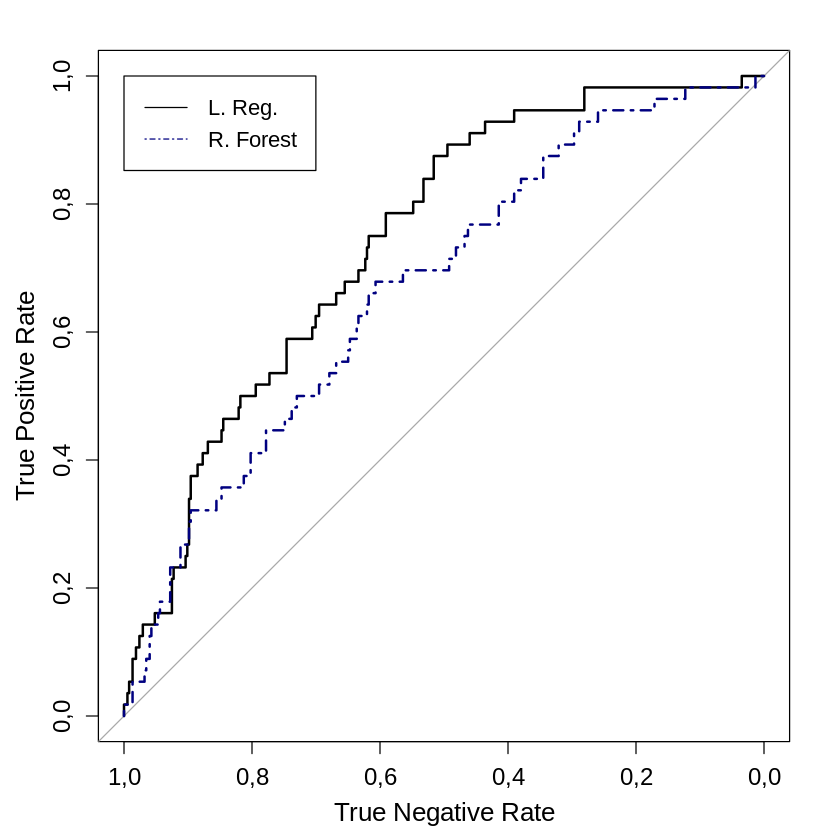

In [90]:
plot(roc_reg_log, xlab="True Negative Rate",
                  ylab="True Positive Rate", cex.lab = 1.3, cex.axis = 1.2)
lines(roc_rf, lty='dotdash', col='navy')
legend(1, 1, legend=c("L. Reg.", "R. Forest"),
       col=c("black", "navy"), lty=c('solid','dotdash'), cex=1.1)

dev.copy(png,'Plots/goodness_fit.png',width=500,height=500,res=75)
dev.off()

### Convergence analysis

#### Diagnostics for the No-U-Turn Sampler

In [300]:
posterior<-as.array(fit)
dim(posterior)

[1] 2500    4   28

In [301]:
available_mcmc(pattern = "_nuts_")

bayesplot MCMC module:
(matching pattern '_nuts_') 
  mcmc_nuts_acceptance
  mcmc_nuts_divergence
  mcmc_nuts_energy
  mcmc_nuts_stepsize
  mcmc_nuts_treedepth

In [302]:
lp_cp <- log_posterior(fit)
head(lp_cp)

Iteration,Value,Chain
1,"-648,1092",1
2,"-650,3185",1
3,"-649,1184",1
4,"-644,3364",1
5,"-653,5326",1
6,"-653,3565",1


In [303]:
np_cp <- nuts_params(fit)
head(np_cp)

Iteration,Parameter,Value,Chain
1,accept_stat__,"0,9963239",1
2,accept_stat__,"0,9602426",1
3,accept_stat__,"0,9068665",1
4,accept_stat__,"0,9759126",1
5,accept_stat__,"0,9989700",1
6,accept_stat__,"0,9042759",1


Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.


png 
  3

png 
  2

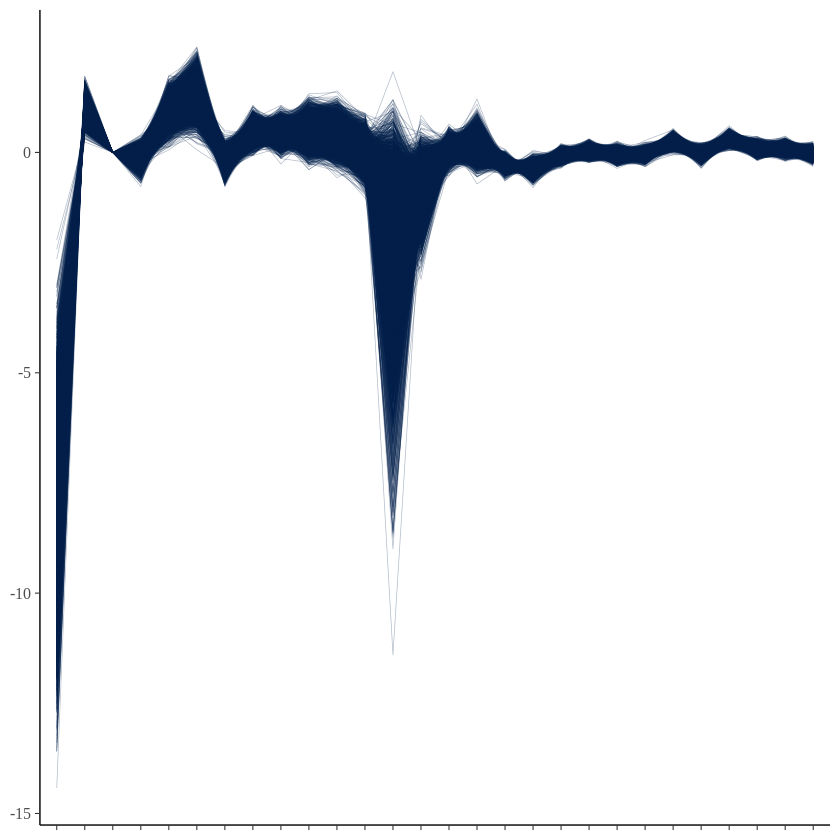

In [307]:
mcmc_parcoord(posterior, np = np_cp)+ scale_x_discrete(name ="Variables") + theme(axis.title.x=element_blank(),
                                                                                  axis.text.x=element_blank())
dev.copy(png,'Plots/transitions_mcmc.png',width=700,height=400,res=100)
dev.off()

#### Generic

In [306]:
posterior<-as.array(fit)
dim(posterior)

table<-monitor(posterior)
table

table<-as.data.frame(table)
row<-rownames(table)
table<-table[,c('Rhat', 'Bulk_ESS', 'Tail_ESS')] #'n_eff'
table<-round(table,2)
table<-apply(table, 2, gsub, patt=",", replace=".")
rownames(table)<-row

#
table<-table[c('(Intercept)', 'grade_2012', 'year', 'semester', 'school_2012.municipal', 
                'school_2012.privada', 'white', 'male', 'failed_before_2012', 'mother_educ.nao_sabe',
                'mother_educ.ef1', 'mother_educ.ef2', 'mother_educ.em', 'mother_educ.superior', 
                'pre_k', 'kinder', 'lang_2012', 'math_2012', 'act_2012', 'aes_2012', 'alt_2012', 'anx_2012', 
                'ass_2012', 'cmp_2012', 'dep_2012', 'ids_2012', 'ord_2012', 'sfd_2012'),]

variables <- c('Intercept', 'Grade 2012', 'Birth Year', 'Birth Semester',
               'School 2012: Municipal', 'School 2012: Private', 'Ethinicity: White', 'Gender: Male', 'Failed Before 2012',
               'Mother Educ.: Unknown', 'Mother Educ.: Elementary', 'Mother Educ.: Middle', 'Mother Educ.: High', 'Mother Educ.: College',
               'Childhood Educ: Pre-k','Childhood Educ: Kinder',
               'Language 2012', 'Mathematics 2012', 
               "Activity", "Aesthetics", "Altruism", "Anxiety", "Assertiveness", 
               "Compliance", "Depression", "Ideas", "Order", "Self-Discipline")

rownames(table) <- variables
#


stargazer(table)

[1] 2500    4   28

Inference for the input samples (4 chains: each with iter = 2500; warmup = 1250):

                         Q5  Q50  Q95 Mean  SD  Rhat Bulk_ESS Tail_ESS
(Intercept)           -10,6 -8,0 -5,5 -8,0 1,6     1     4994     4928
grade_2012              0,7  1,0  1,3  1,0 0,2     1     4852     4839
year                    0,0  0,0  0,0  0,0 0,0     1     5111     5008
semester               -0,4 -0,1  0,1 -0,1 0,2     1     4639     4872
school_2012.municipal   0,6  0,9  1,3  0,9 0,2     1     5190     5031
school_2012.privada     0,8  1,3  1,8  1,3 0,3     1     4823     4648
white                  -0,5 -0,2  0,1 -0,2 0,2     1     5084     4911
male                    0,2  0,5  0,7  0,5 0,2     1     4856     4780
failed_before_2012      0,2  0,5  0,7  0,5 0,2     1     5142     4724
mother_educ.ef1         0,1  0,5  0,8  0,5 0,2     1     4849     4910
mother_educ.ef2         0,0  0,4  0,8  0,4 0,3     1     4836     4907
mother_educ.em         -0,4  0,0  0,4  0,0 0,3     1     4796    

,mean,se_mean,sd,"2,5%",25%,50%,75%,"97,5%",n_eff,Rhat,⋯,Q50,Q95,"MCSE_Q2,5",MCSE_Q25,MCSE_Q50,MCSE_Q75,"MCSE_Q97,5",MCSE_SD,Bulk_ESS,Tail_ESS
(Intercept),"-8,0474147858","2,198202e-02","1,5534105020","-11,014278469","-9,088651106","-8,0434256772","-7,0158576719","-5,0006484151",4987,"1,0002054",⋯,"-8,0434256772","-5,4505725743","5,274975e-02","3,555816e-02","2,827060e-02","3,014563e-02","0,0520796938","1,554454e-02",4994,4928
grade_2012,"1,0122198823","2,857588e-03","0,1991604615","0,616990245","0,879482205","1,0134876763","1,1463918590","1,4006982189",4799,"0,9999222",⋯,"1,0134876763","1,3336747898","6,298516e-03","2,974716e-03","3,881815e-03","4,121457e-03","0,0085058856","2,049652e-03",4852,4839
year,"-0,0004367392","6,396071e-06","0,0004570539","-0,001305539","-0,000745806","-0,0004333479","-0,0001438816","0,0004736637",5095,"1,0007713",⋯,"-0,0004333479","0,0003183217","1,585072e-05","7,292209e-06","7,993701e-06","9,661165e-06","0,0000223987","4,554345e-06",5111,5008
semester,"-0,1383225543","2,209778e-03","0,1504864223","-0,429881168","-0,238821383","-0,1420876047","-0,0379699294","0,1569655371",4600,"0,9997013",⋯,"-0,1420876047","0,1096476490","6,857390e-03","2,594706e-03","2,017398e-03","3,054042e-03","0,0054069200","1,562647e-03",4639,4872
school_2012.municipal,"0,9392470303","3,201445e-03","0,2306137534","0,487815194","0,780892193","0,9404947104","1,0959402625","1,3890986040",5177,"1,0002803",⋯,"0,9404947104","1,3177652324","6,379947e-03","4,972388e-03","3,871278e-03","3,846132e-03","0,0099917800","2,263891e-03",5190,5031
school_2012.privada,"1,3357274582","4,403872e-03","0,3058946091","0,711956323","1,135877282","1,3400943806","1,5372103337","1,9330081152",4767,"1,0002991",⋯,"1,3400943806","1,8360985996","1,274299e-02","5,127538e-03","6,008390e-03","6,319035e-03","0,0090460368","3,124395e-03",4823,4648
white,"-0,1921788998","2,296042e-03","0,1637670617","-0,511828848","-0,297909681","-0,1913582701","-0,0808980632","0,1215556718",5081,"0,9995838",⋯,"-0,1913582701","0,0755149962","6,191815e-03","3,295050e-03","3,259470e-03","4,019763e-03","0,0065306171","1,623640e-03",5084,4911
male,"0,4653003400","2,335455e-03","0,1626127083","0,152829389","0,353050810","0,4656625256","0,5760173297","0,7841125153",4824,"0,9999094",⋯,"0,4656625256","0,7312570206","5,150612e-03","2,806873e-03","2,890450e-03","2,912247e-03","0,0040584962","1,651516e-03",4856,4780
failed_before_2012,"0,4548360810","2,360267e-03","0,1695767291","0,116120039","0,342828003","0,4562192735","0,5707488183","0,7839795030",5148,"1,0000894",⋯,"0,4562192735","0,7330102988","4,620968e-03","3,178449e-03","3,005477e-03","3,855642e-03","0,0081066938","1,696761e-03",5142,4724
mother_educ.ef1,"0,4613299891","3,418953e-03","0,2381207456","0,001560124","0,298228016","0,4643494394","0,6217288583","0,9214949755",4846,"1,0004217",⋯,"0,4643494394","0,8494905057","1,108401e-02","4,751868e-03","3,237838e-03","5,365409e-03","0,0073446651","2,417710e-03",4849,4910



% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: seg, nov 18, 2019 - 15:27:07
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} cccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Rhat & Bulk\_ESS & Tail\_ESS \\ 
\hline \\[-1.8ex] 
Intercept & 1 & 4994 & 4928 \\ 
Grade 2012 & 1 & 4852 & 4839 \\ 
Birth Year & 1 & 5111 & 5008 \\ 
Birth Semester & 1 & 4639 & 4872 \\ 
School 2012: Municipal & 1 & 5190 & 5031 \\ 
School 2012: Private & 1 & 4823 & 4648 \\ 
Ethinicity: White & 1 & 5084 & 4911 \\ 
Gender: Male & 1 & 4856 & 4780 \\ 
Failed Before 2012 & 1 & 5142 & 4724 \\ 
Mother Educ.: Unknown & 1 & 5094 & 4391 \\ 
Mother Educ.: Elementary & 1 & 4849 & 4910 \\ 
Mother Educ.: Middle & 1 & 4836 & 4907 \\ 
Mother Educ.: High & 1 & 4796 & 4400 \\ 
Mother Educ.: College & 1 & 5050 & 4870 \\ 
Childhood Educ: Pre-k & 1 & 5016 & 5119 \\ 
Childhood Educ: Kinder & 1 & 5125 & 4758 \\ 
Lan

In [998]:
(as.numeric(table[,2])+as.numeric(table[,3]))/10000

[1] 0,9922 0,9691 1,0119 0,9511 1,0221 0,9471 0,9995 0,9636 0,9866 0,9759
[11] 0,9743 0,9196 0,9485 0,9920 1,0135 0,9883 0,9395 0,9726 0,9991 0,9549
[21] 1,0033 0,9886 1,0200 0,9527 0,9940 0,9350 0,9555 0,9872

In [981]:
r_scale <- function(x) {
  S <- length(x)
  r <- rank(x, ties.method = 'average')
  if (!is.null(dim(x))) {
    # output should have the input dimension
    r <- array(r, dim = dim(x), dimnames = dimnames(x))
  }
  r
}

mcmc_hist_r_scale <- function(x, nbreaks = 50, ...) {
  max <- prod(dim(x)[1:2])
  bayesplot::mcmc_hist(
    r_scale(x), 
    breaks = seq(0, max, by = max / nbreaks) + 0.5,
    ...
  ) +
    theme(axis.line.y = element_blank())
}

In [999]:
for(i in colnames(posterior[,1,])){
    print(paste('convergence/',i,'.png',sep=''))
}

[1] "convergence/(Intercept).png"
[1] "convergence/grade_2012.png"
[1] "convergence/year.png"
[1] "convergence/semester.png"
[1] "convergence/school_2012.municipal.png"
[1] "convergence/school_2012.privada.png"
[1] "convergence/white.png"
[1] "convergence/male.png"
[1] "convergence/failed_before_2012.png"
[1] "convergence/mother_educ.ef1.png"
[1] "convergence/mother_educ.ef2.png"
[1] "convergence/mother_educ.em.png"
[1] "convergence/mother_educ.nao_sabe.png"
[1] "convergence/mother_educ.superior.png"
[1] "convergence/pre_k.png"
[1] "convergence/kinder.png"
[1] "convergence/lang_2012.png"
[1] "convergence/math_2012.png"
[1] "convergence/act_2012.png"
[1] "convergence/aes_2012.png"
[1] "convergence/alt_2012.png"
[1] "convergence/anx_2012.png"
[1] "convergence/ass_2012.png"
[1] "convergence/cmp_2012.png"
[1] "convergence/dep_2012.png"
[1] "convergence/ids_2012.png"
[1] "convergence/ord_2012.png"
[1] "convergence/sfd_2012.png"


[1] "(Intercept)"


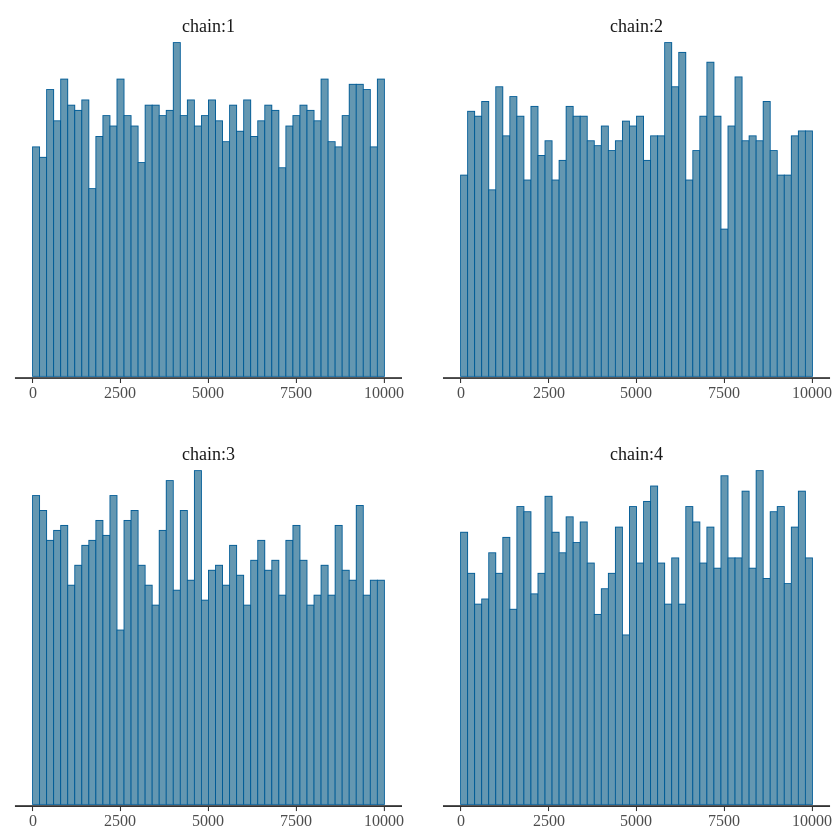

[1] "grade_2012"


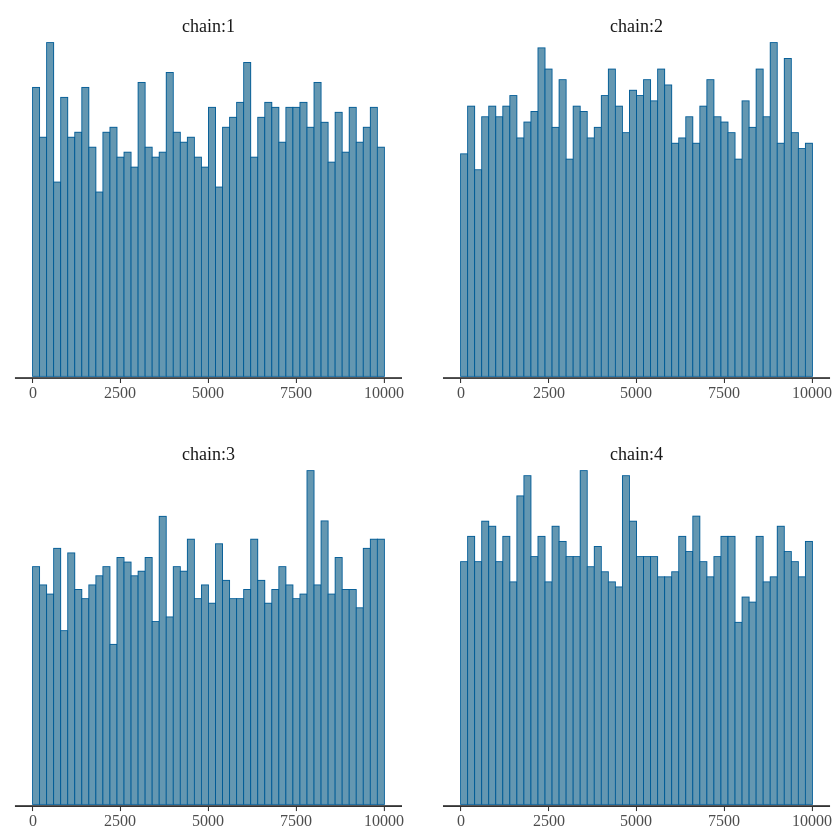

[1] "year"


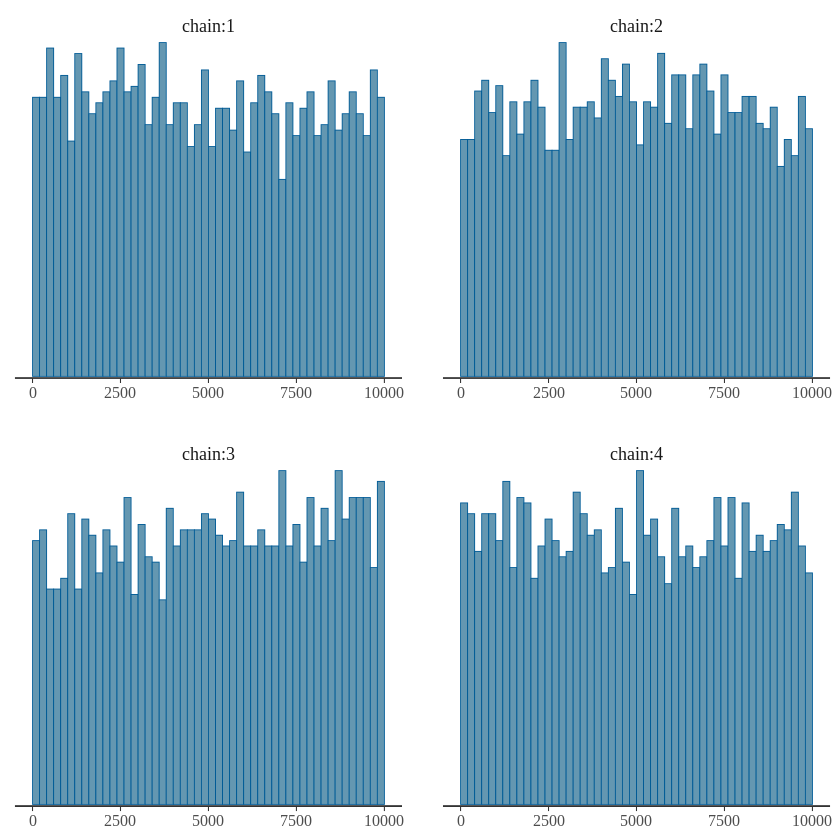

[1] "semester"


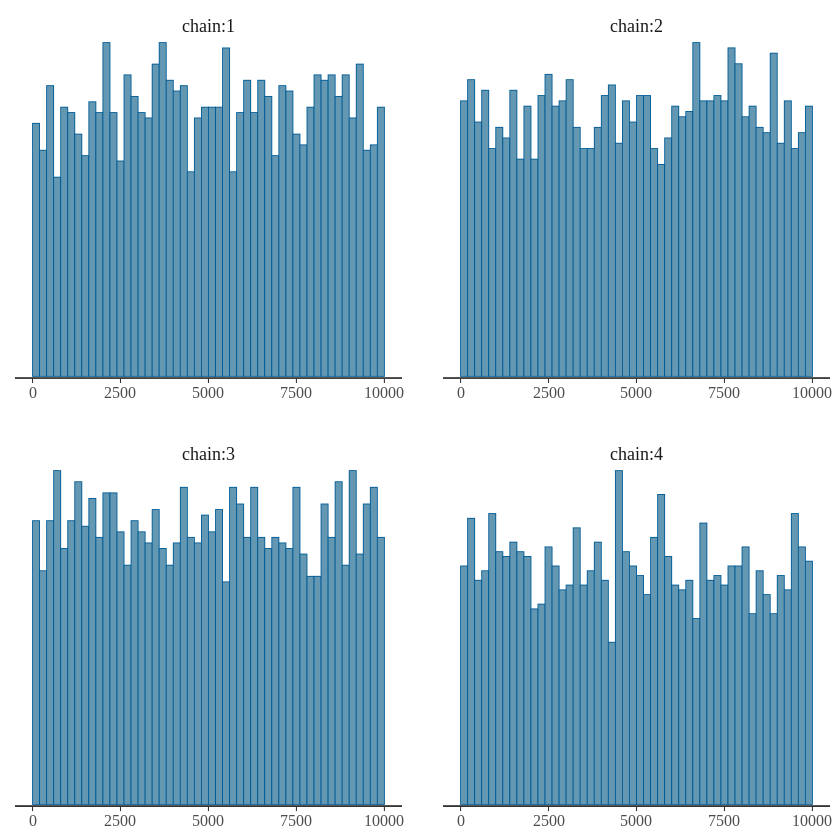

[1] "school_2012.municipal"


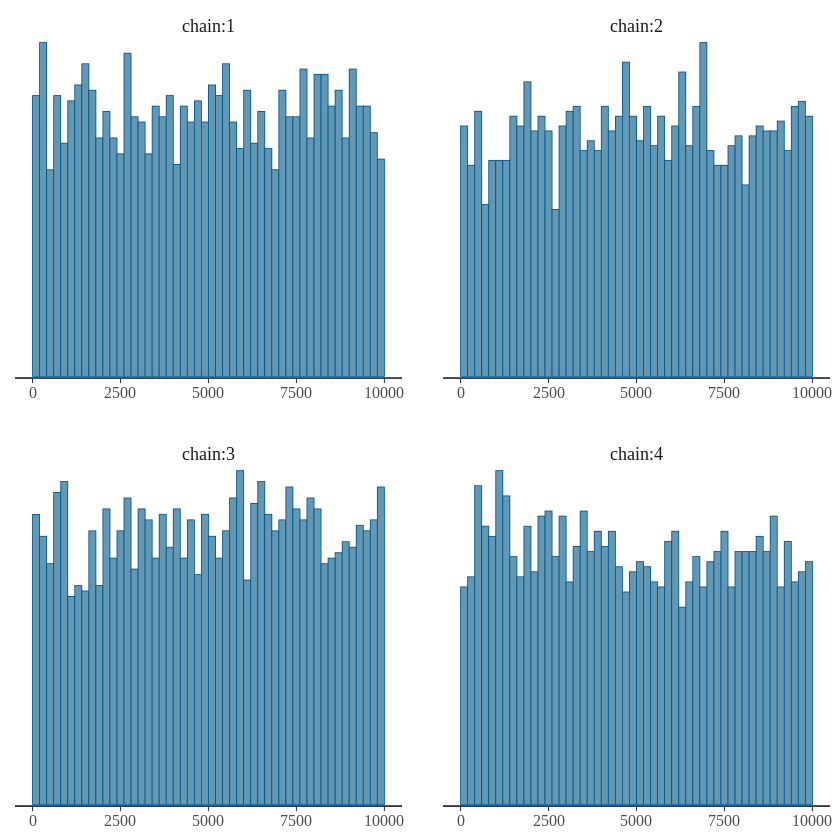

[1] "school_2012.privada"


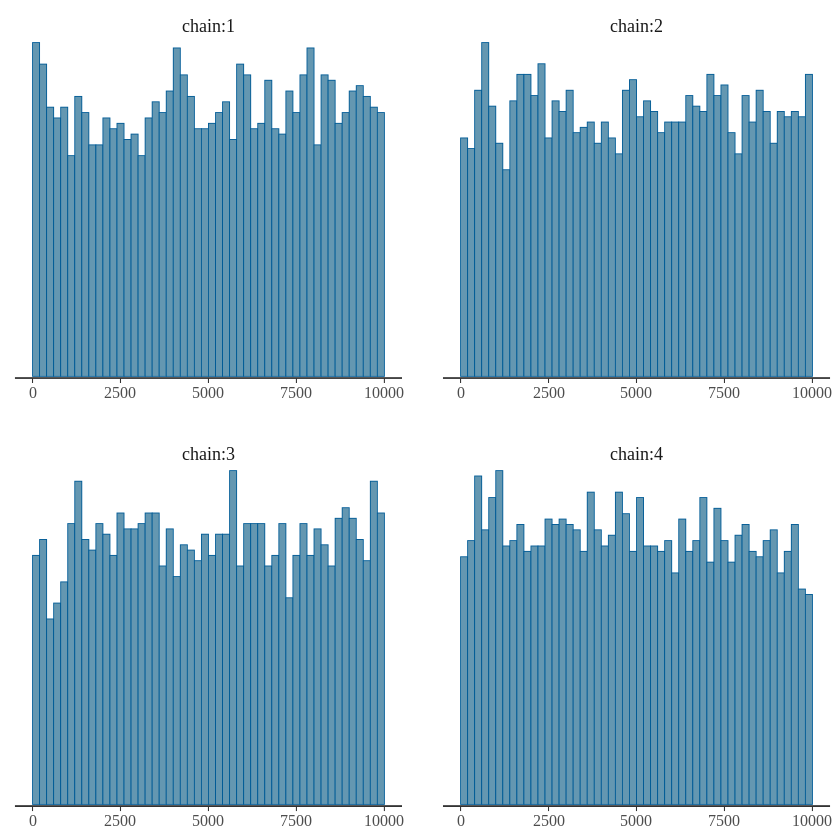

[1] "white"


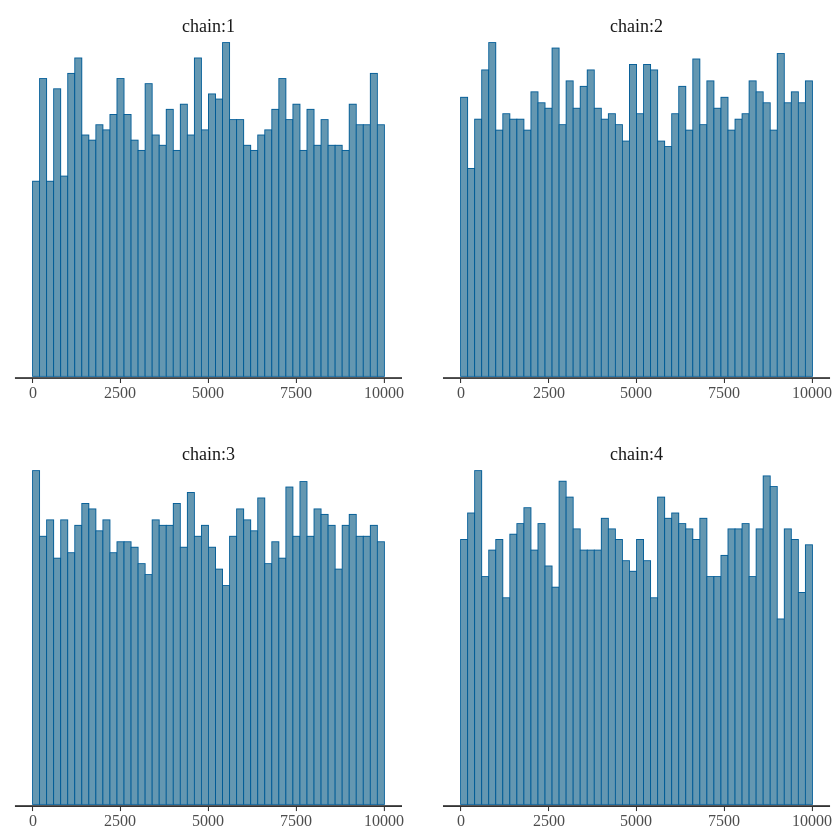

[1] "male"


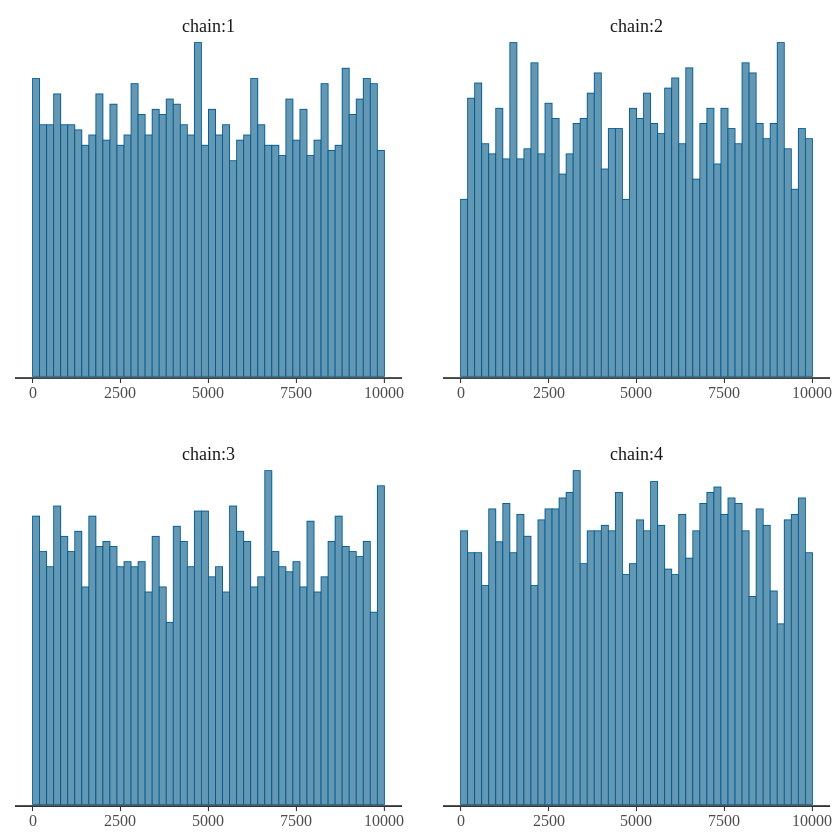

[1] "failed_before_2012"


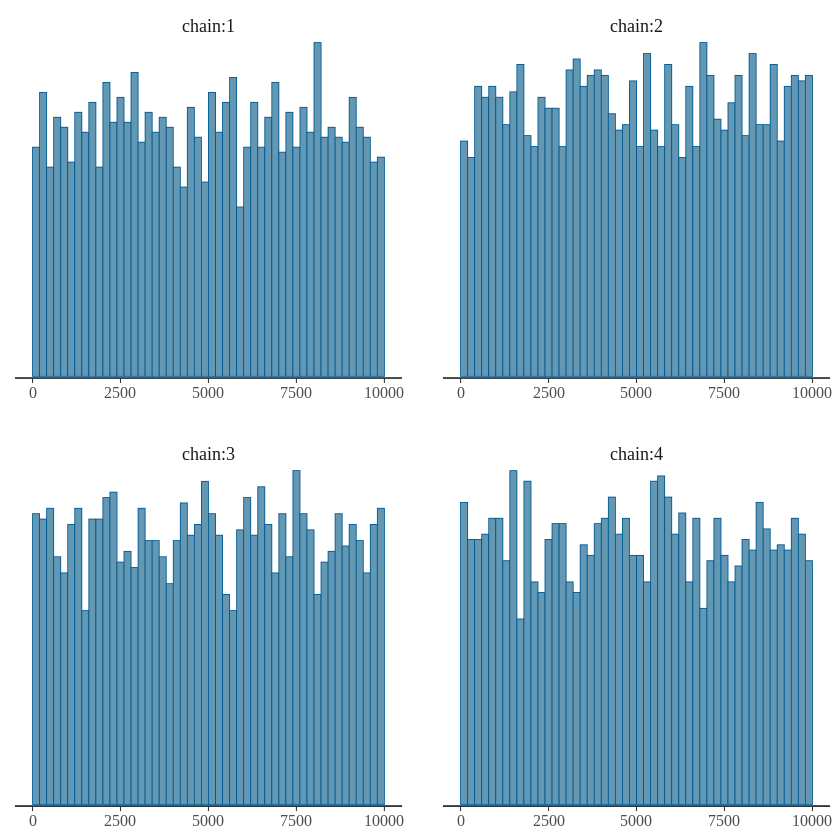

[1] "mother_educ.ef1"


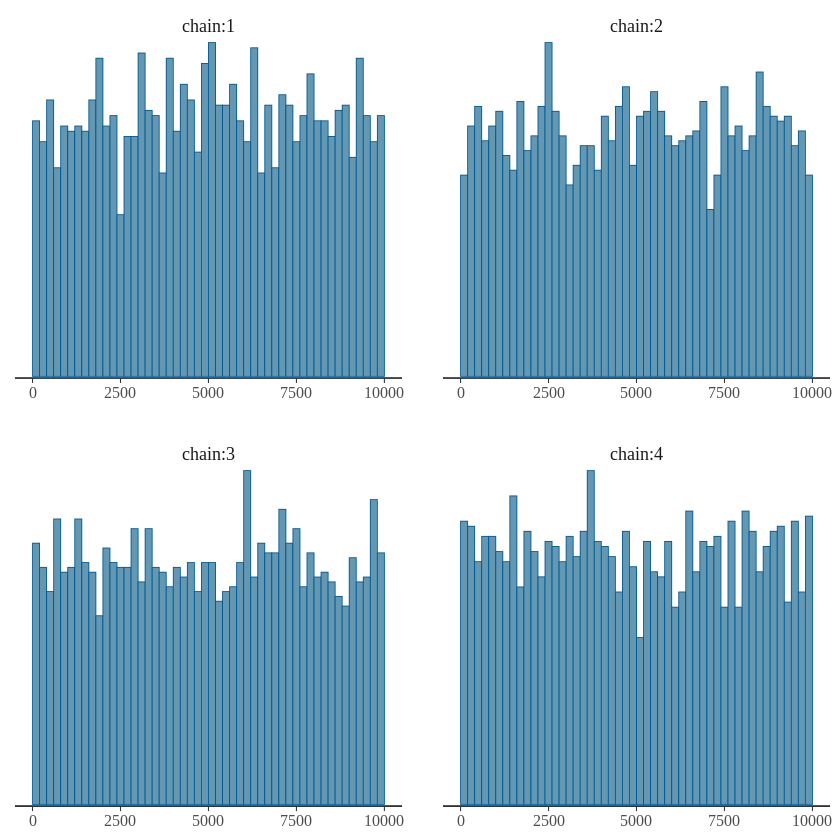

[1] "mother_educ.ef2"


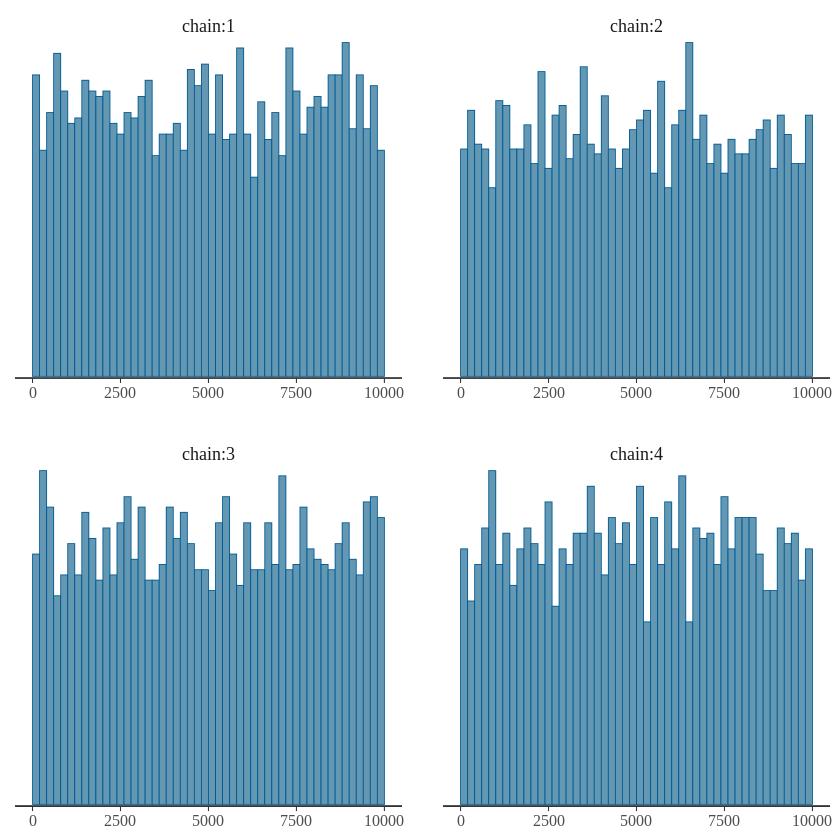

[1] "mother_educ.em"


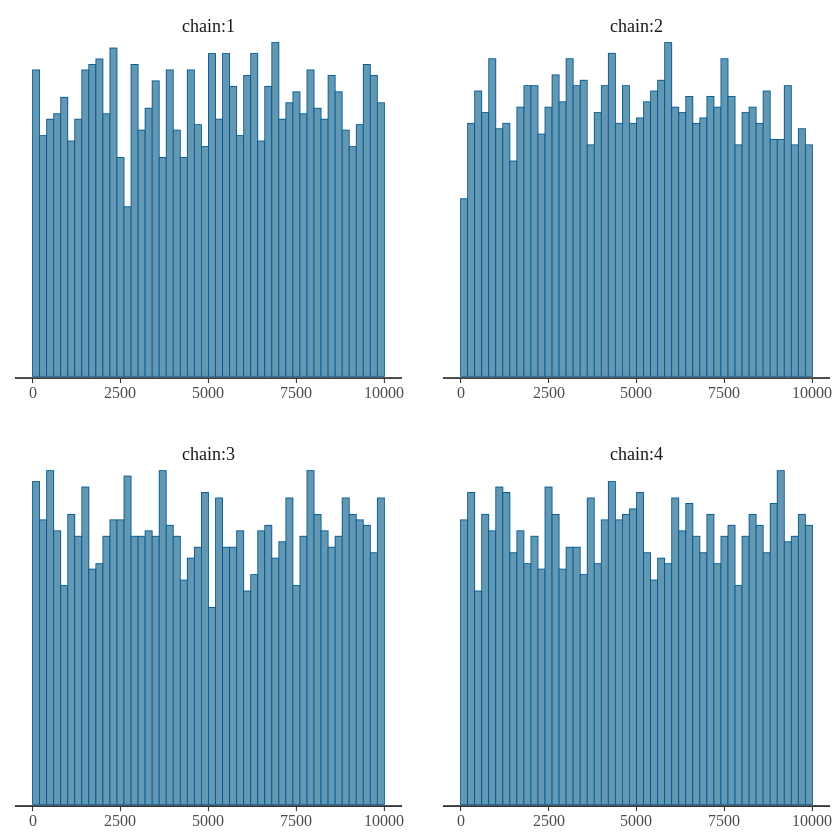

[1] "mother_educ.nao_sabe"


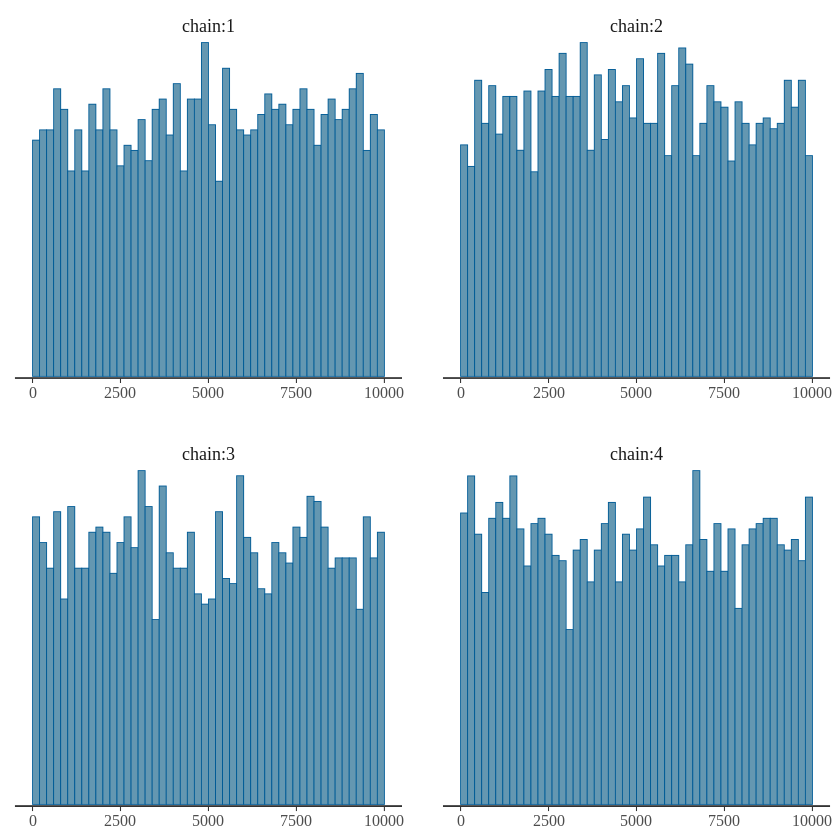

[1] "mother_educ.superior"


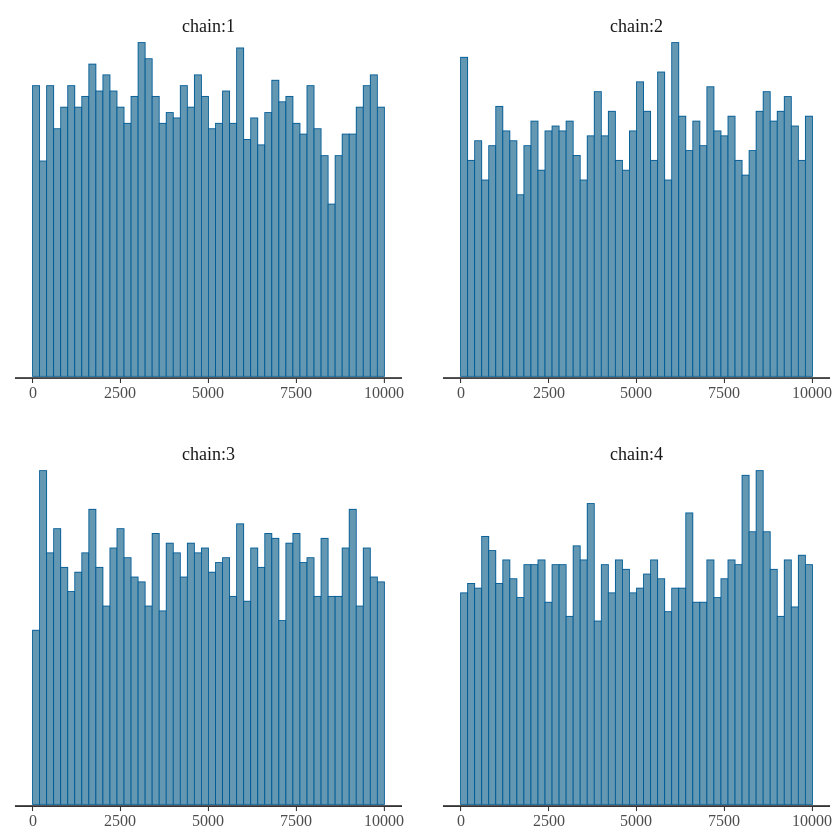

[1] "pre_k"


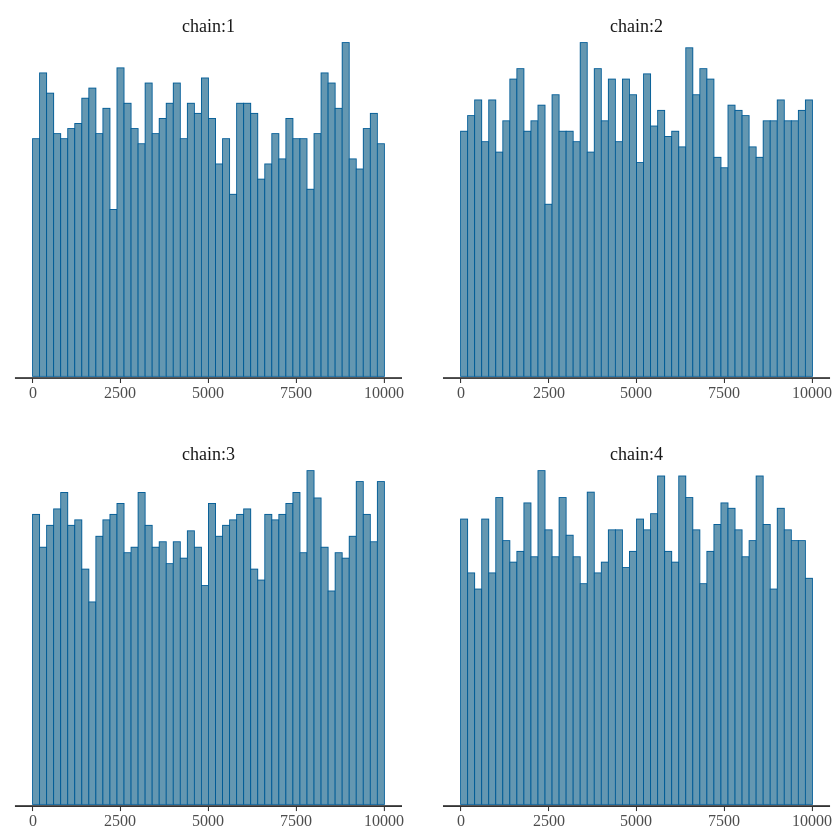

[1] "kinder"


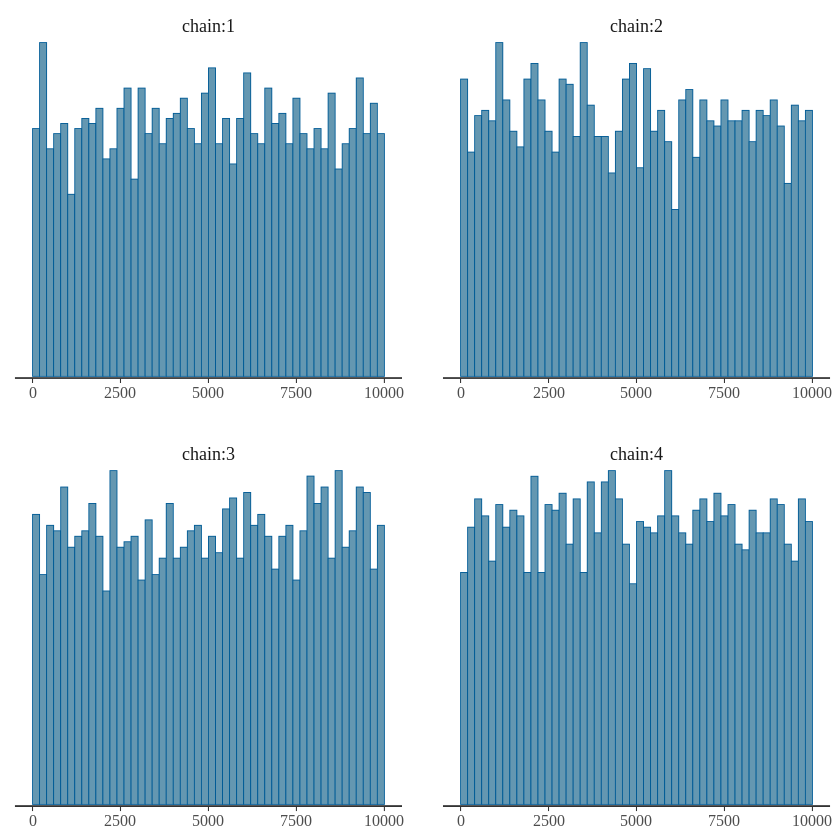

[1] "lang_2012"


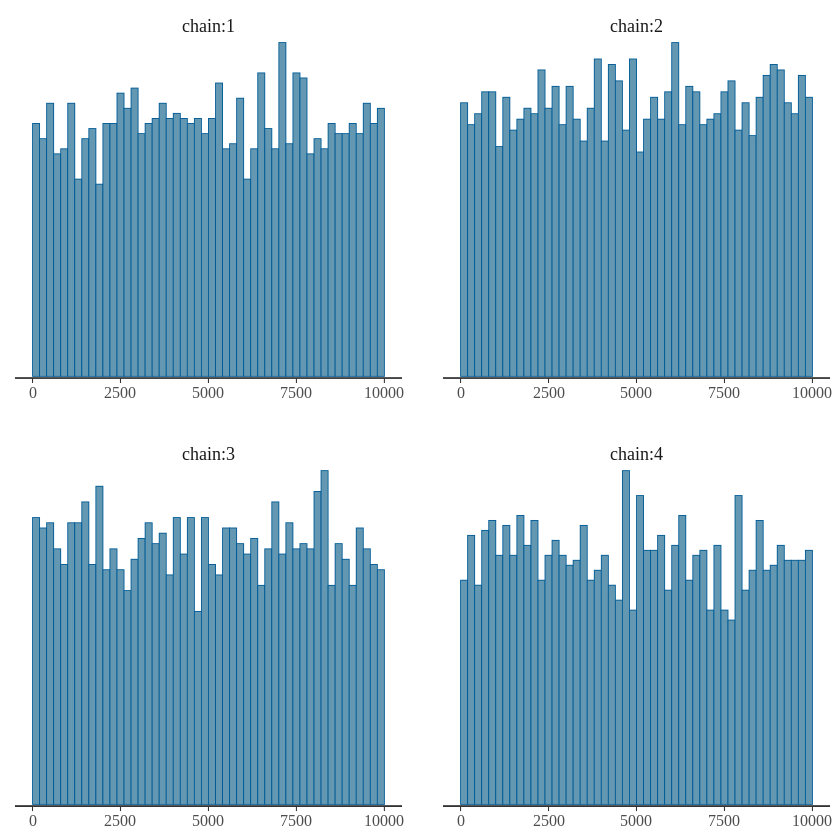

[1] "math_2012"


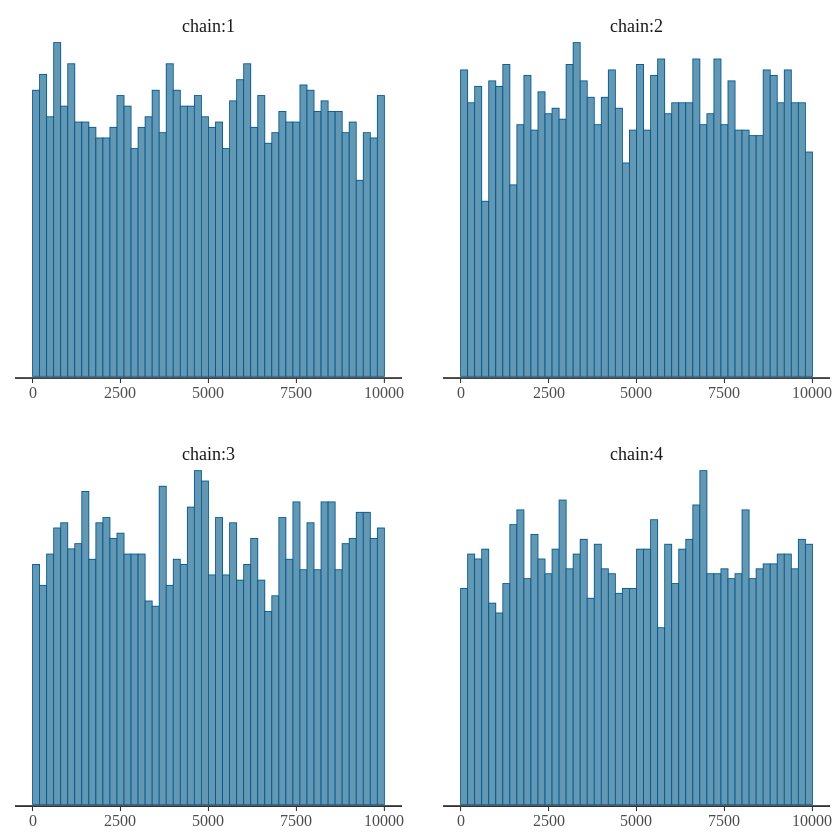

[1] "act_2012"


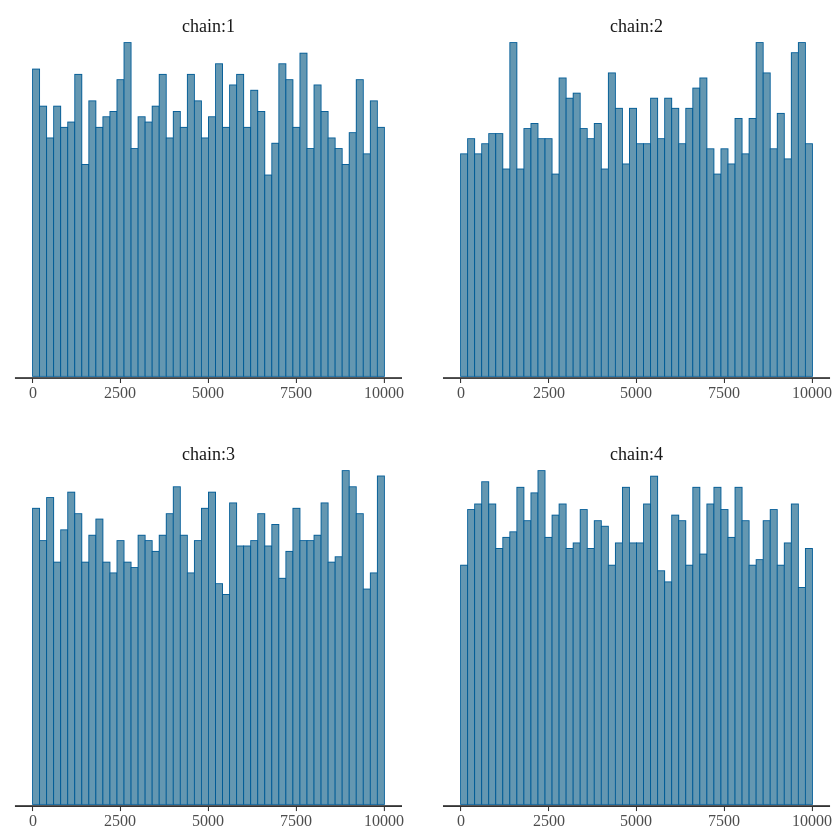

[1] "aes_2012"


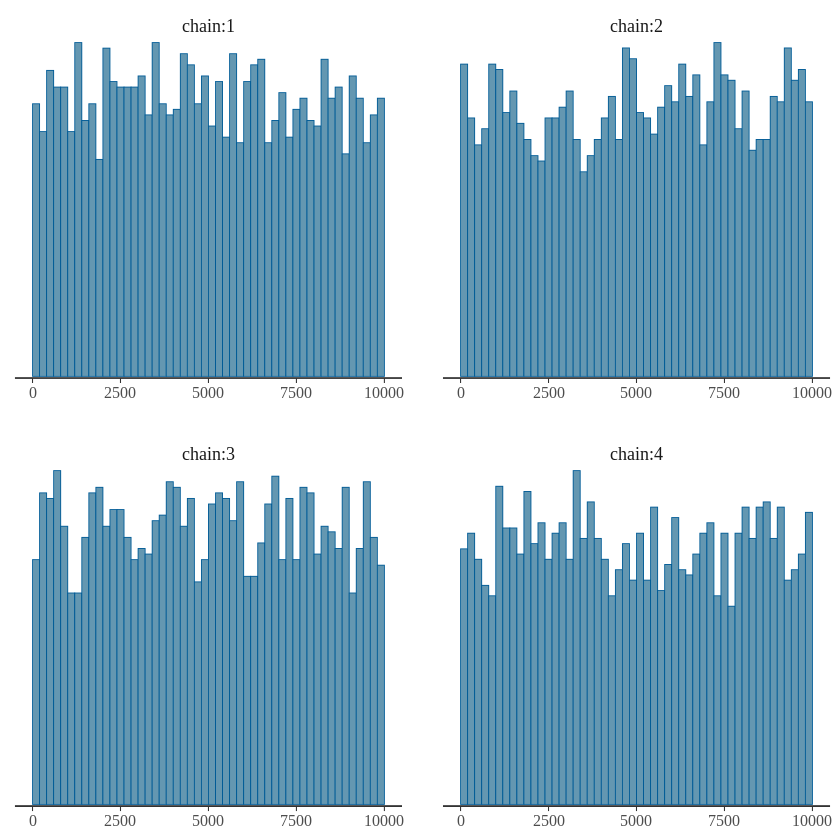

[1] "alt_2012"


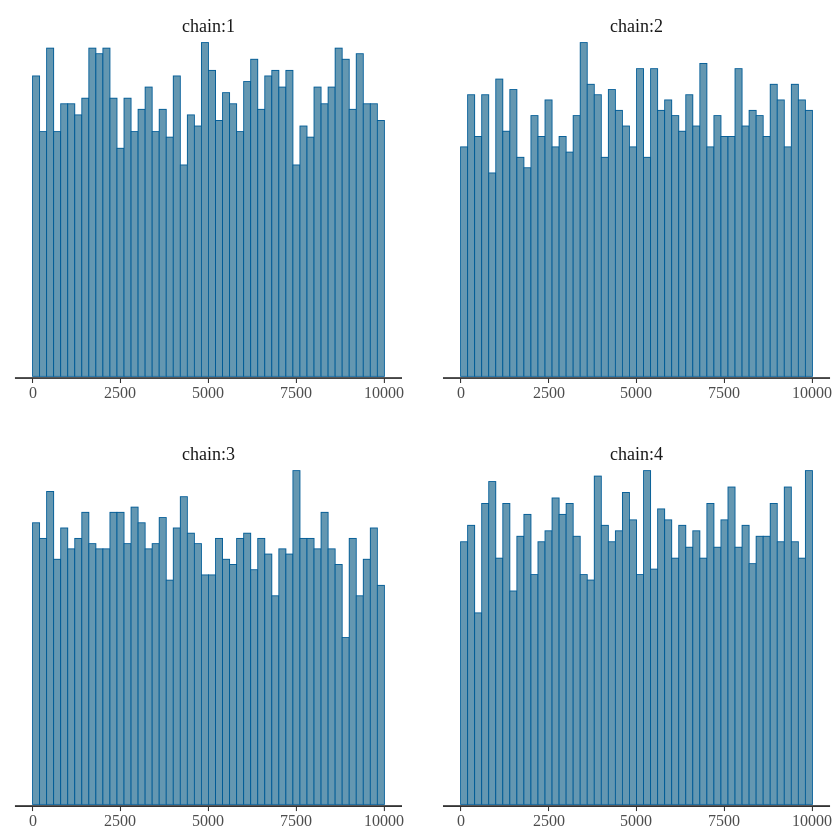

[1] "anx_2012"


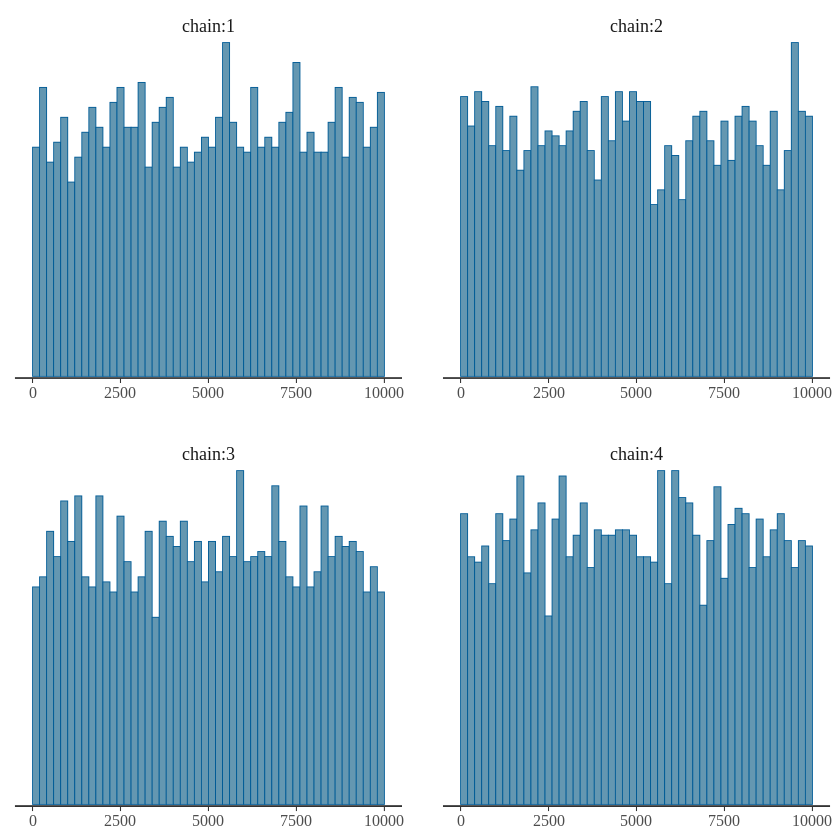

[1] "ass_2012"


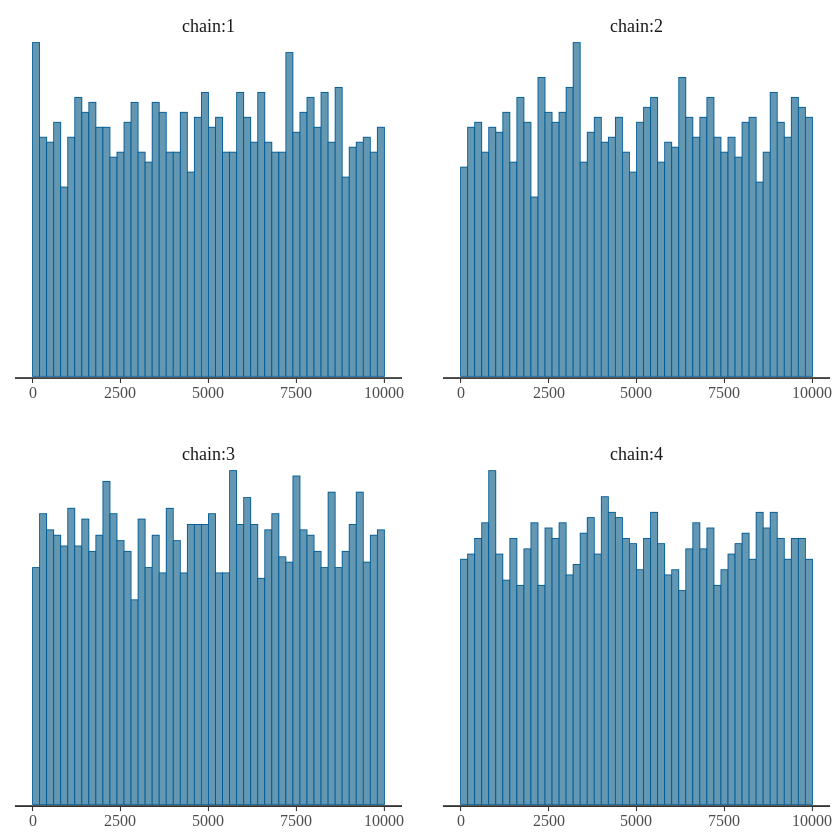

[1] "cmp_2012"


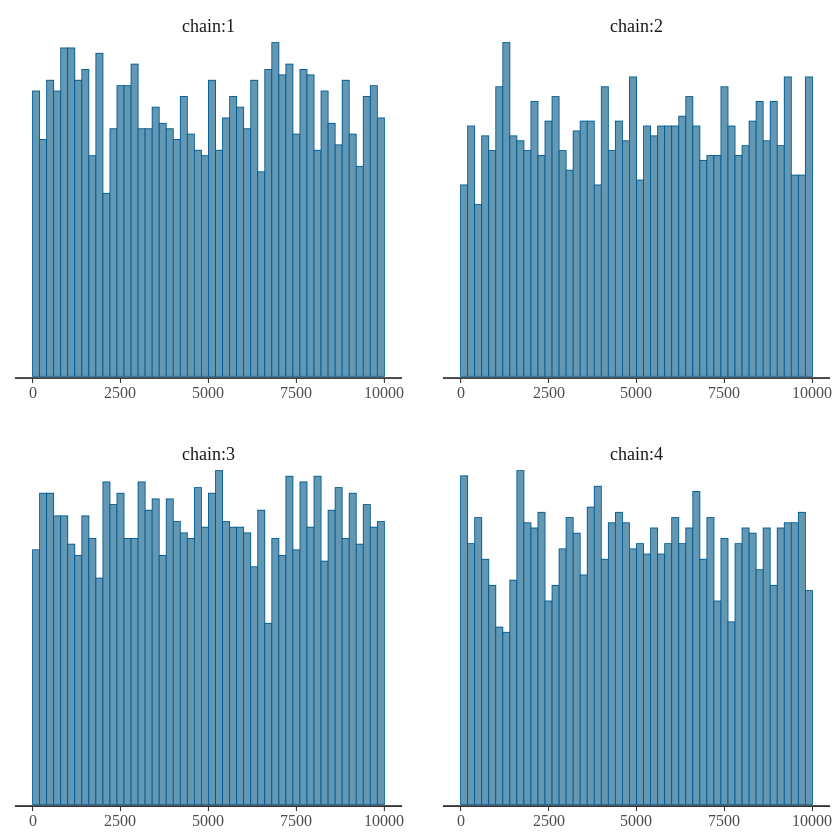

[1] "dep_2012"


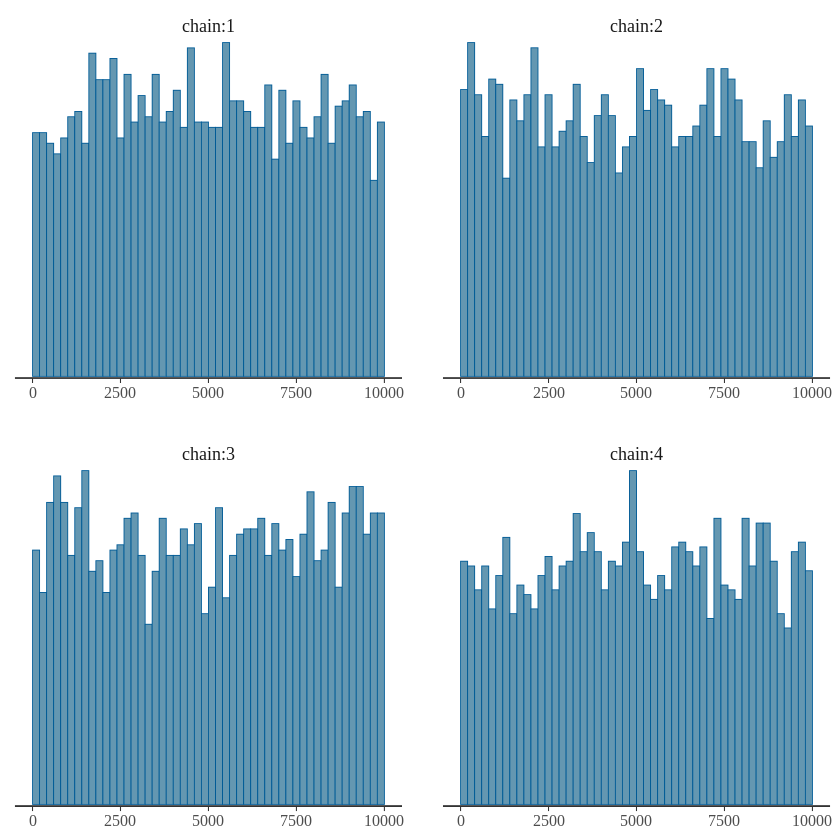

[1] "ids_2012"


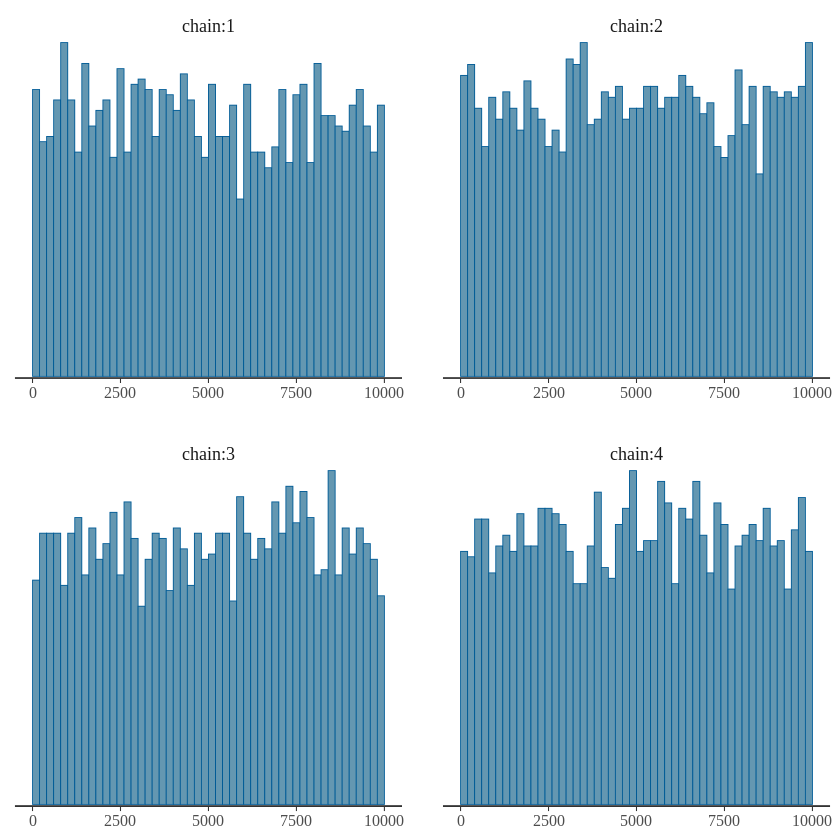

[1] "ord_2012"


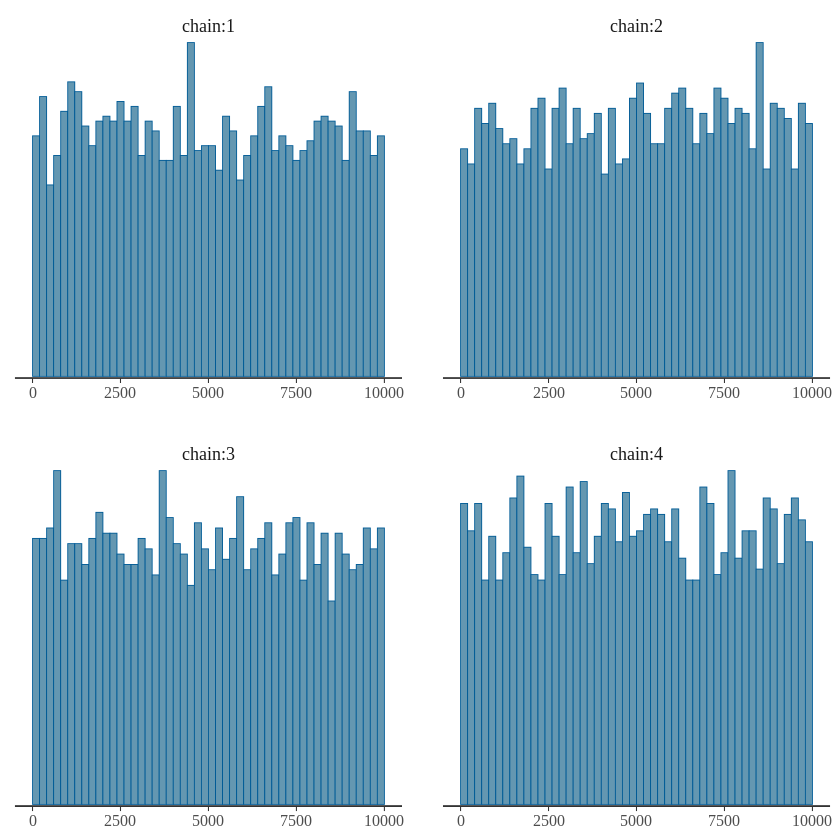

[1] "sfd_2012"


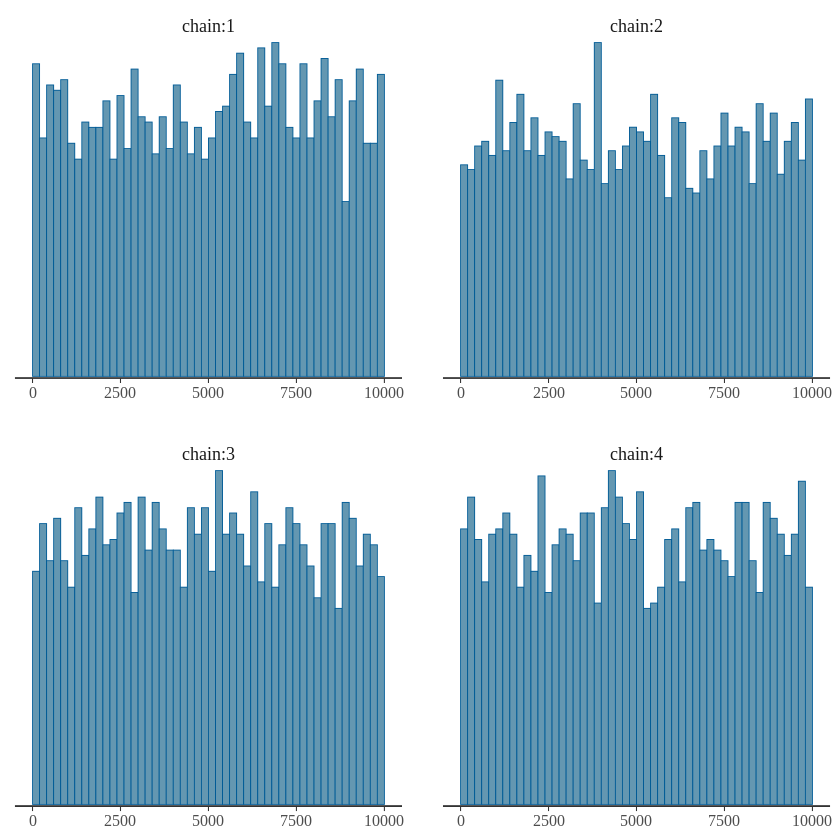

In [982]:
for(i in colnames(posterior[,1,])){
    print(mcmc_hist_r_scale(posterior[,,i]))                                                                                   
    dev.copy(png, paste('Plots/',i,'.png',sep=''),width=600,height=500,res=100)
    dev.off()
    print(i)
}

In [107]:
posterior<-as.array(fit)
dim(posterior)

[1] 2500    4   28

[1] "(Intercept)"


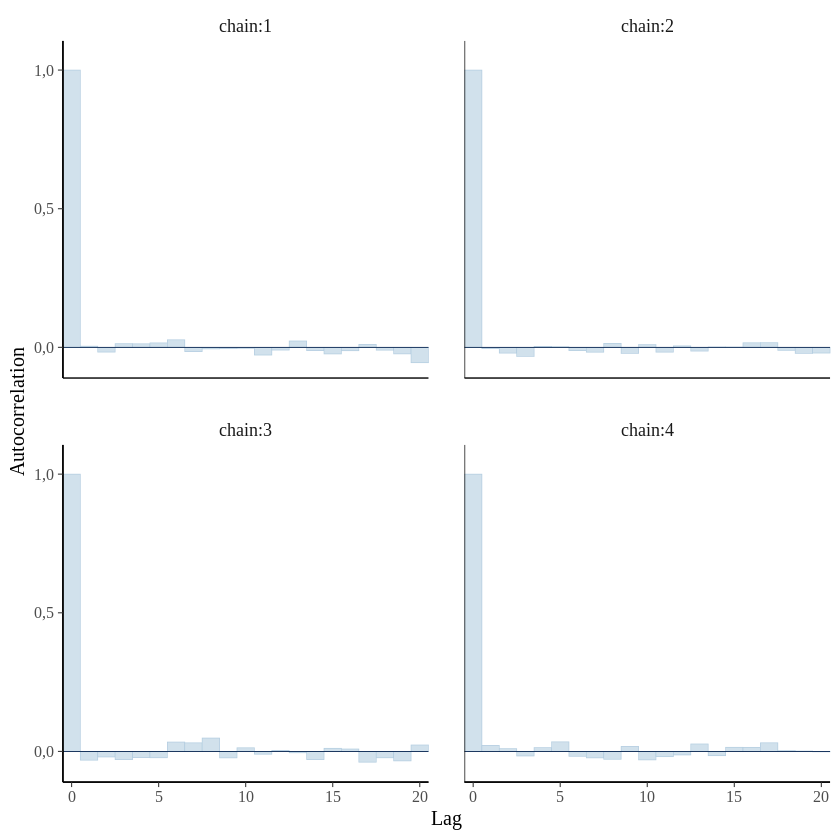

[1] "grade_2012"


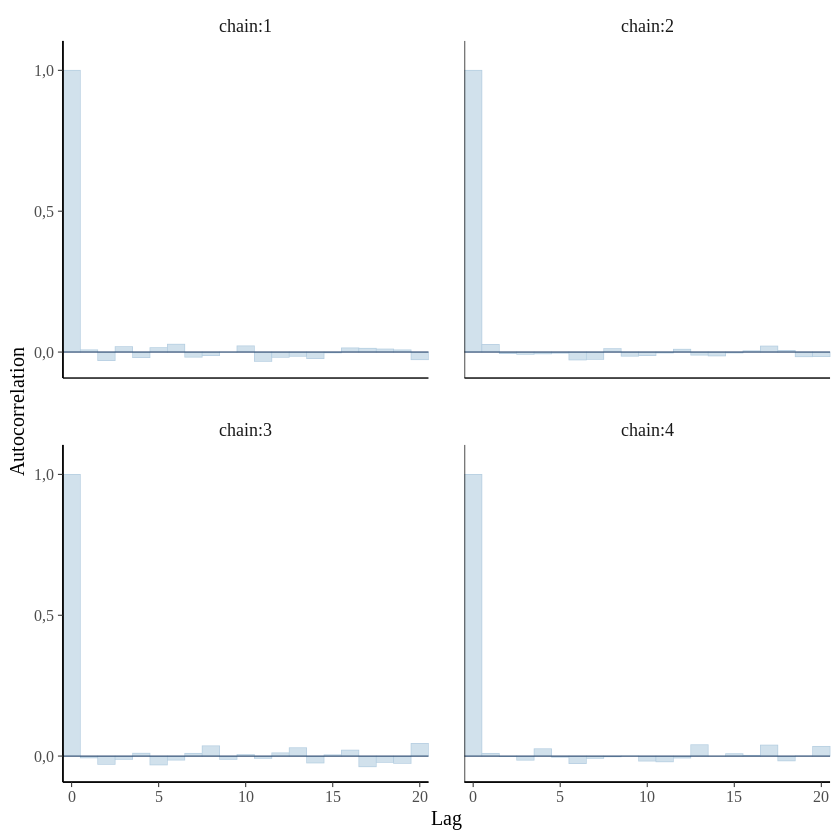

[1] "year"


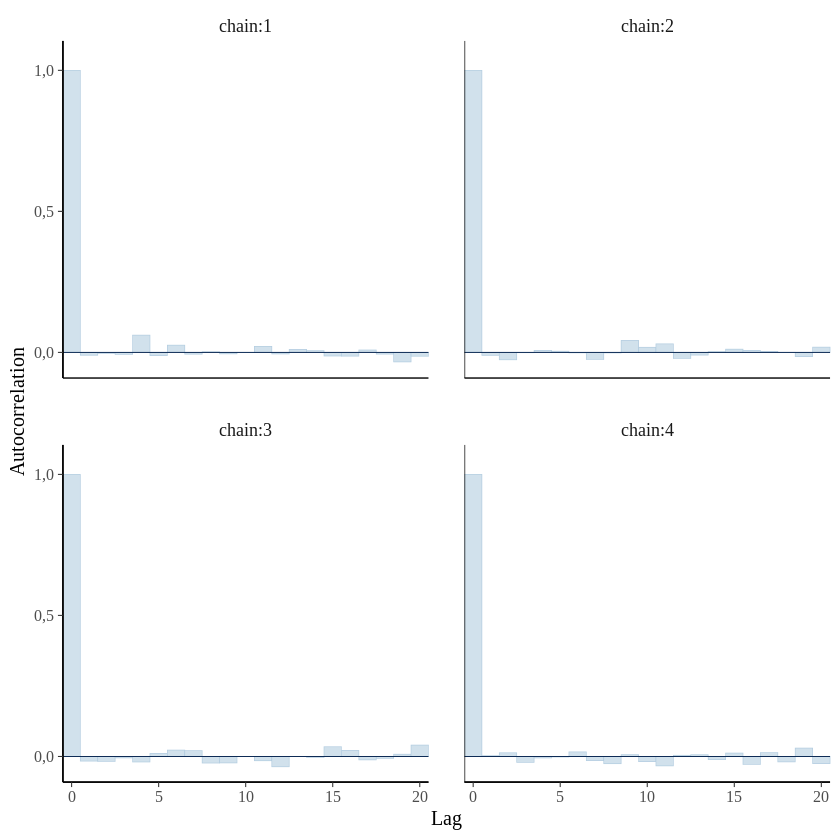

[1] "semester"


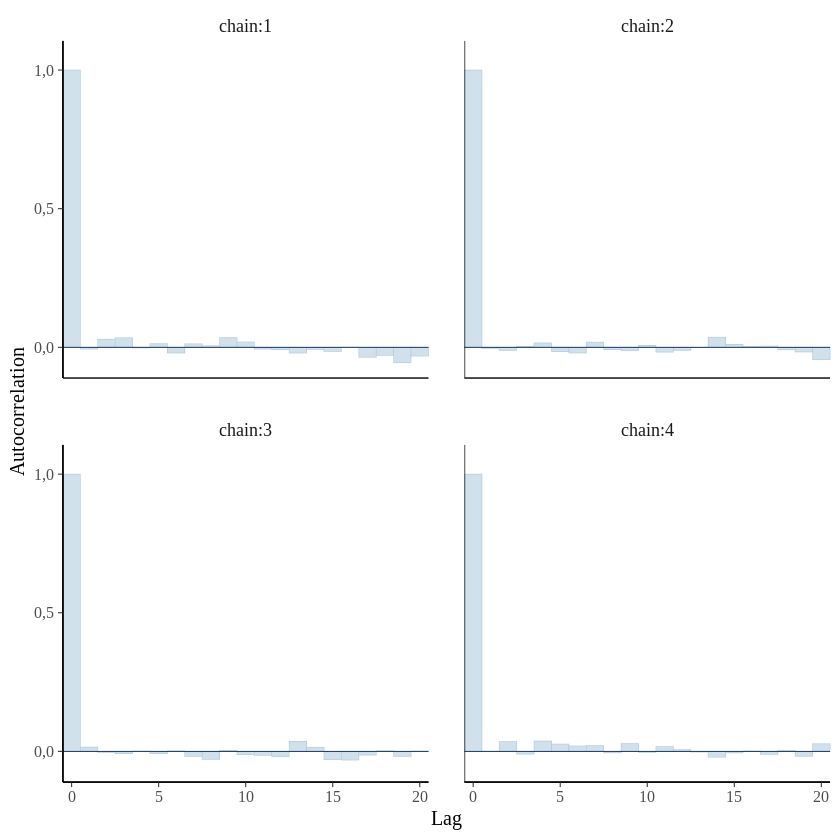

[1] "school_2012.municipal"


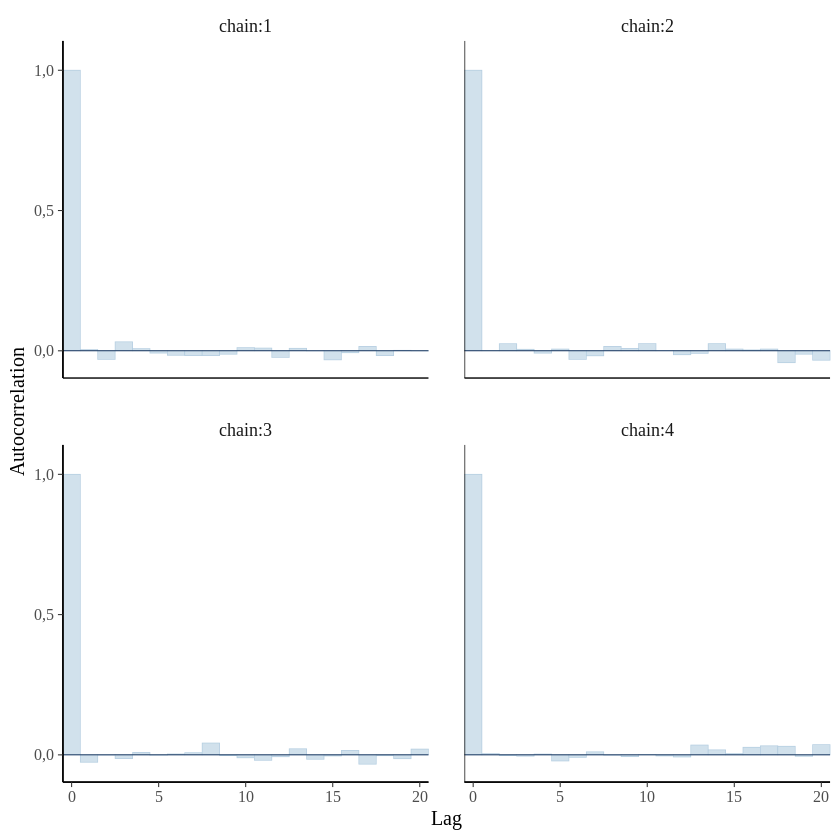

[1] "school_2012.privada"


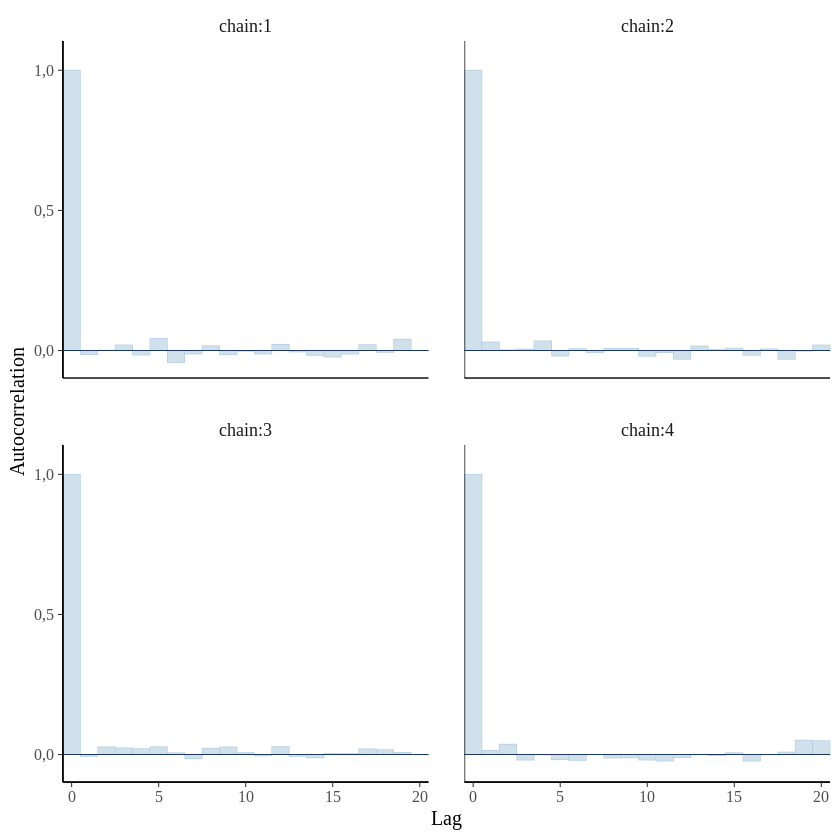

[1] "white"


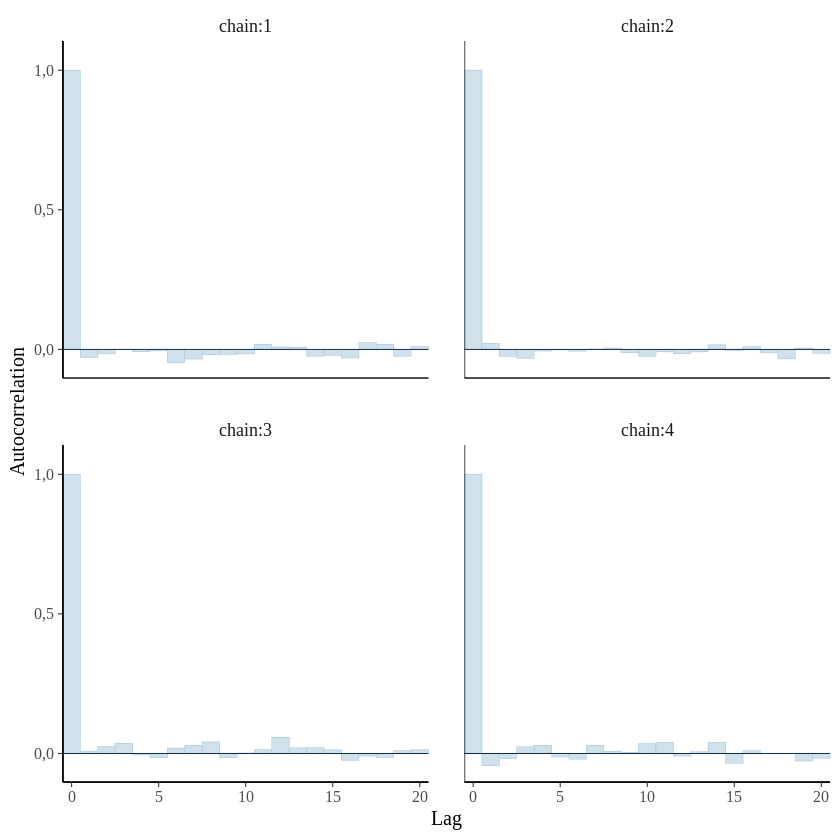

[1] "male"


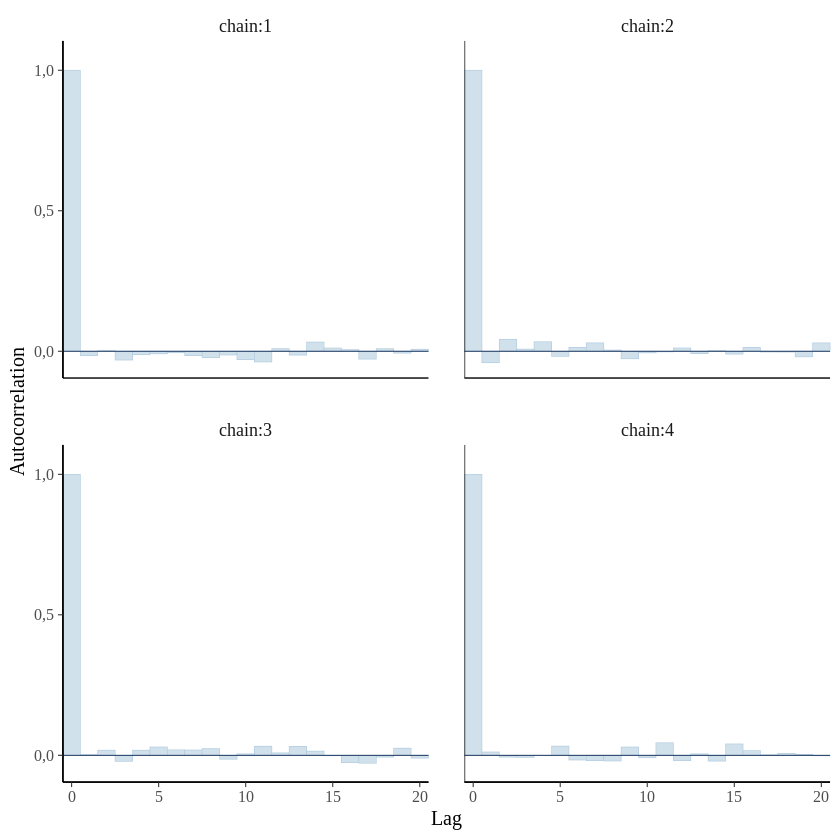

[1] "failed_before_2012"


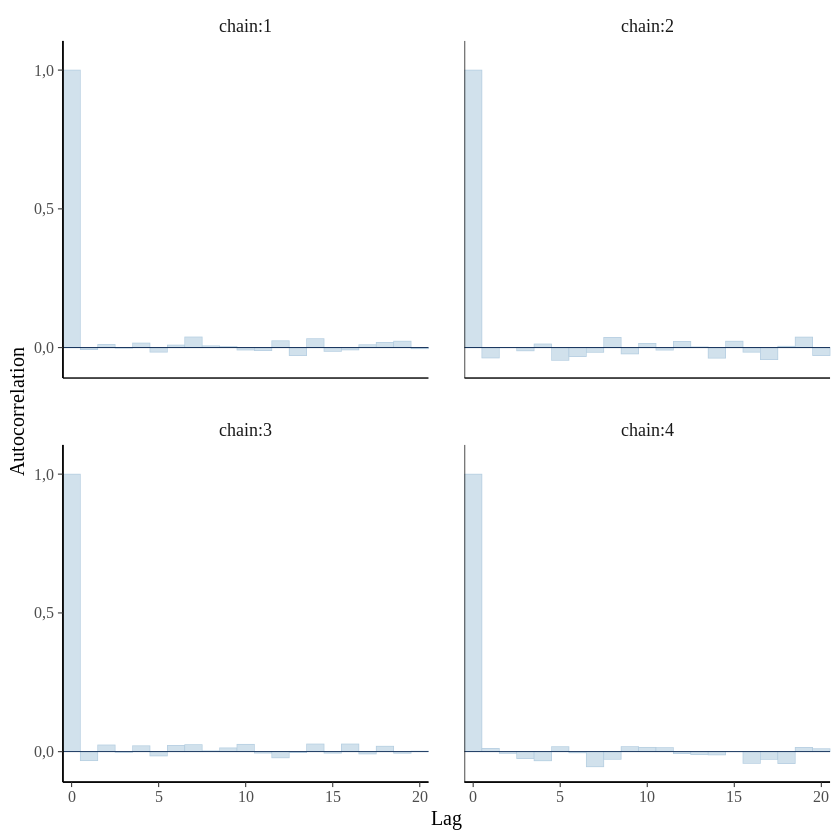

[1] "mother_educ.ef1"


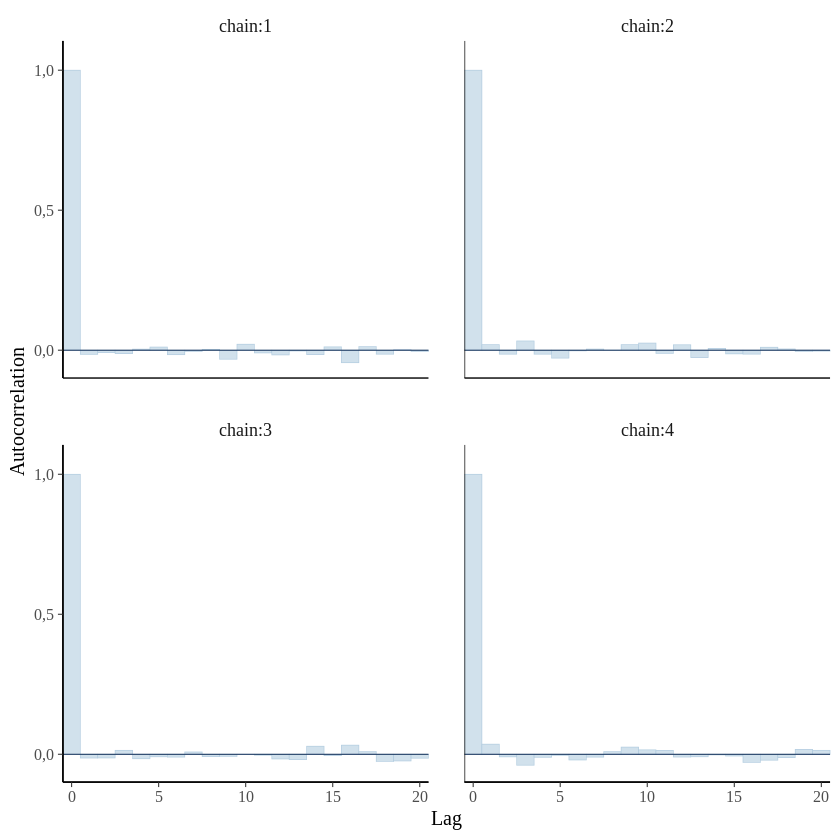

[1] "mother_educ.ef2"


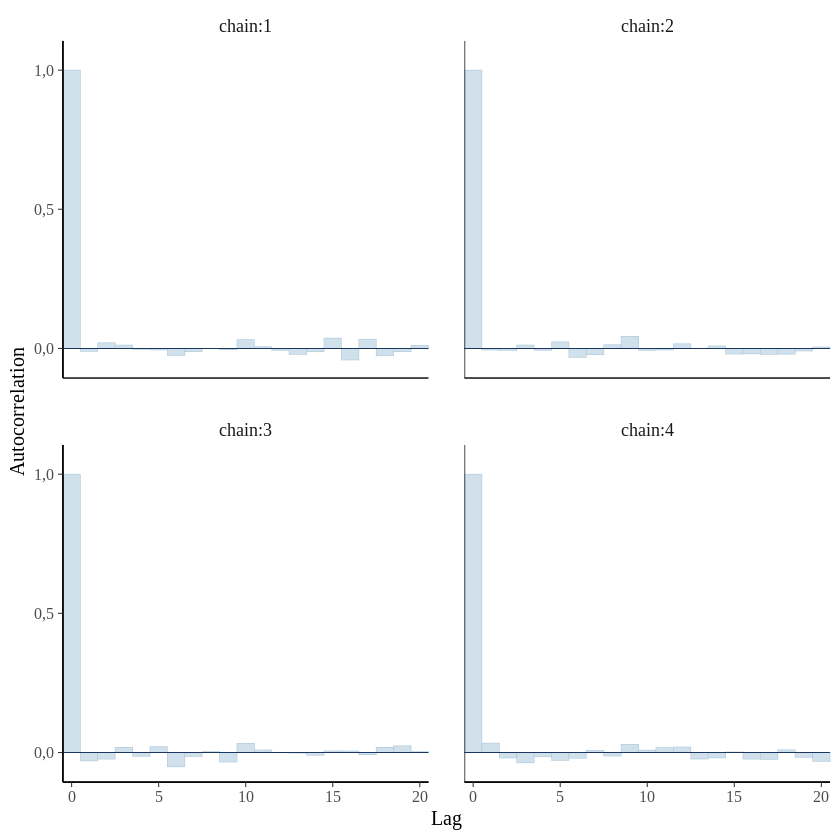

[1] "mother_educ.em"


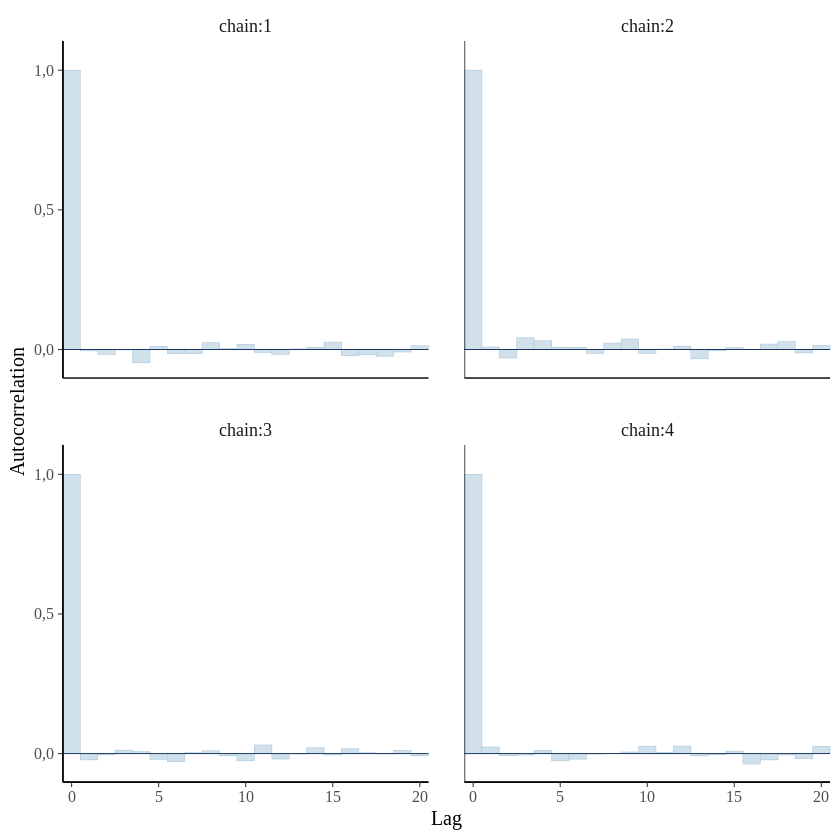

[1] "mother_educ.nao_sabe"


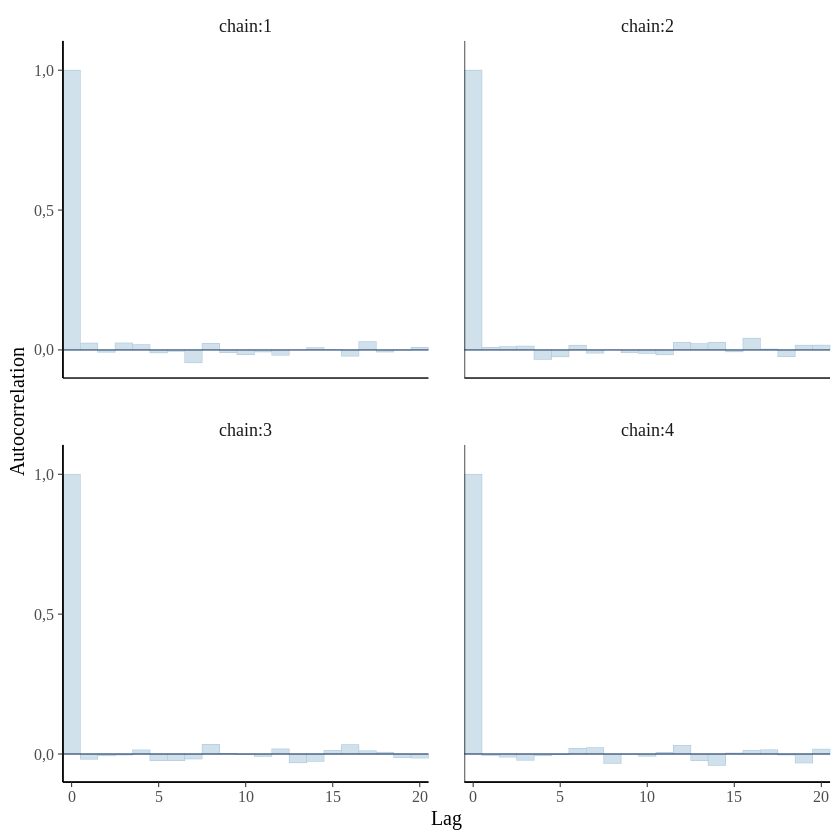

[1] "mother_educ.superior"


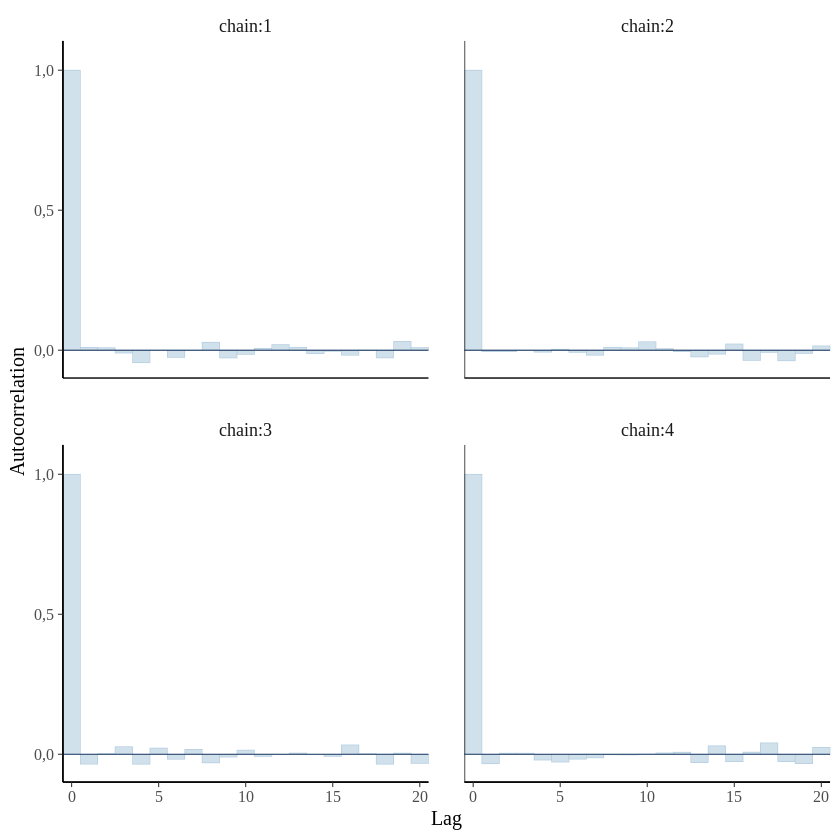

[1] "pre_k"


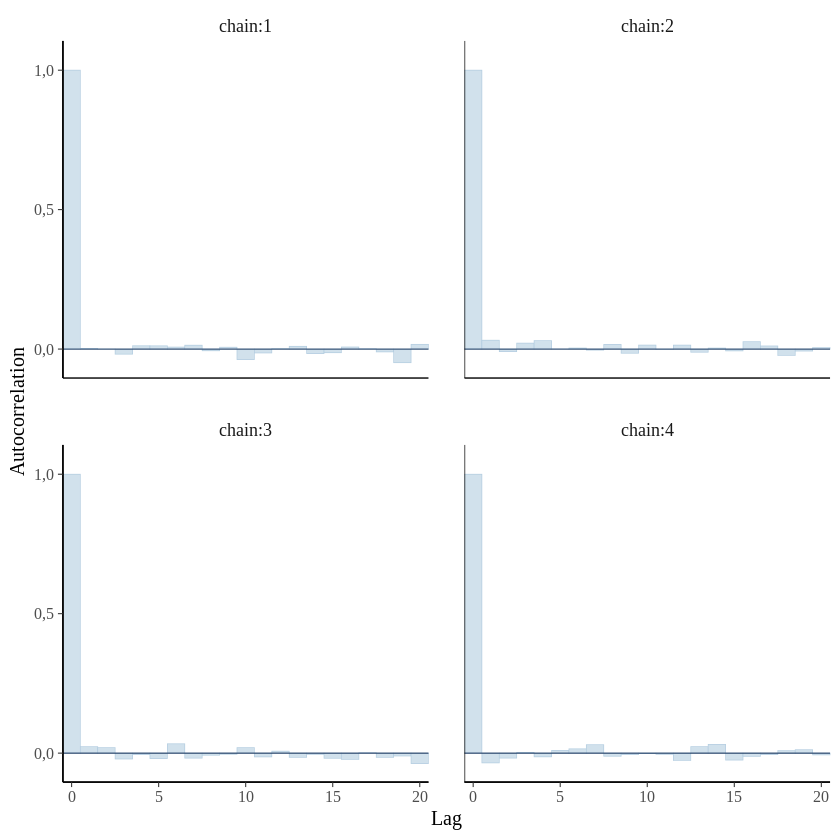

[1] "kinder"


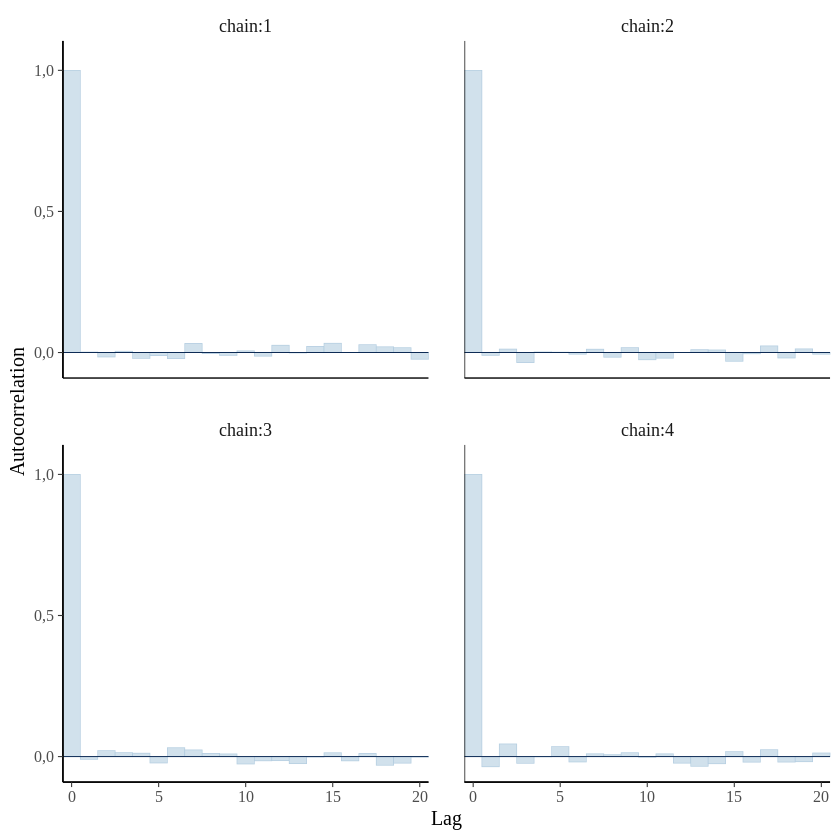

[1] "lang_2012"


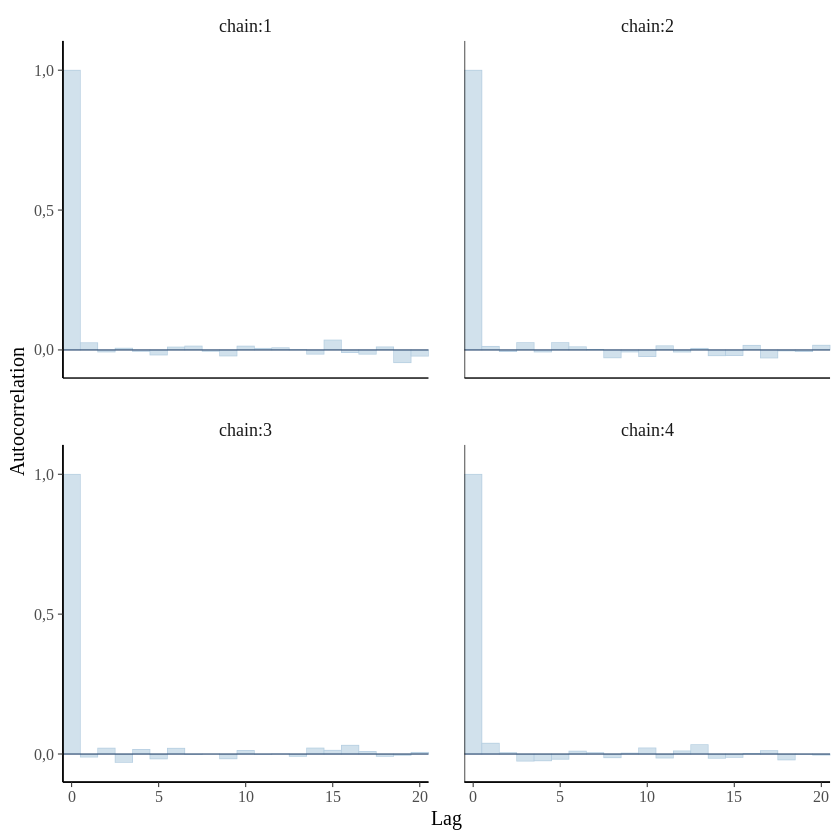

[1] "math_2012"


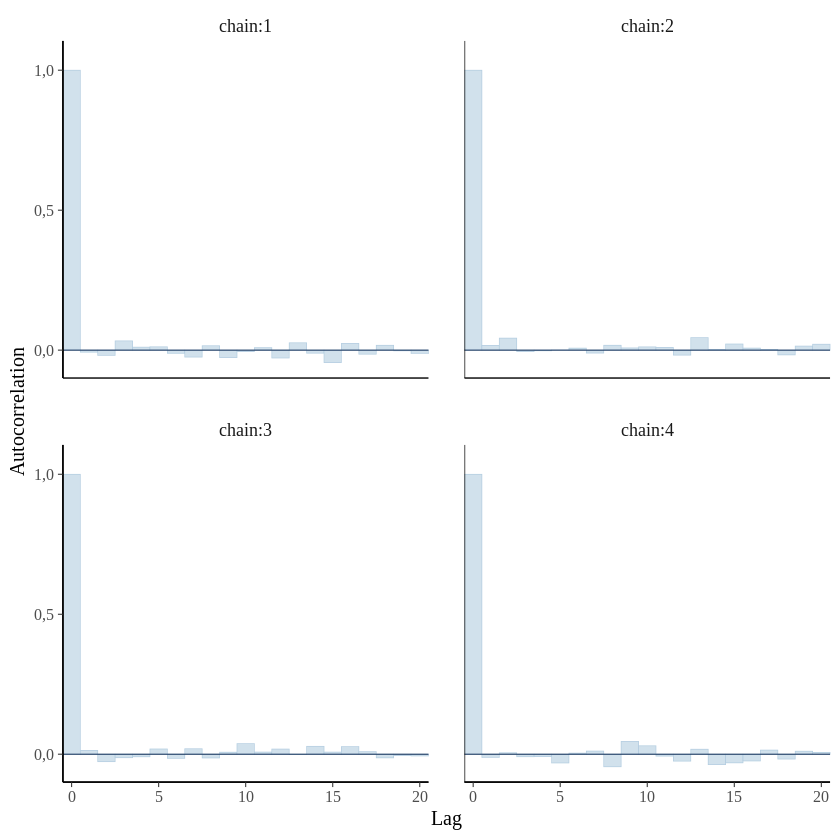

[1] "act_2012"


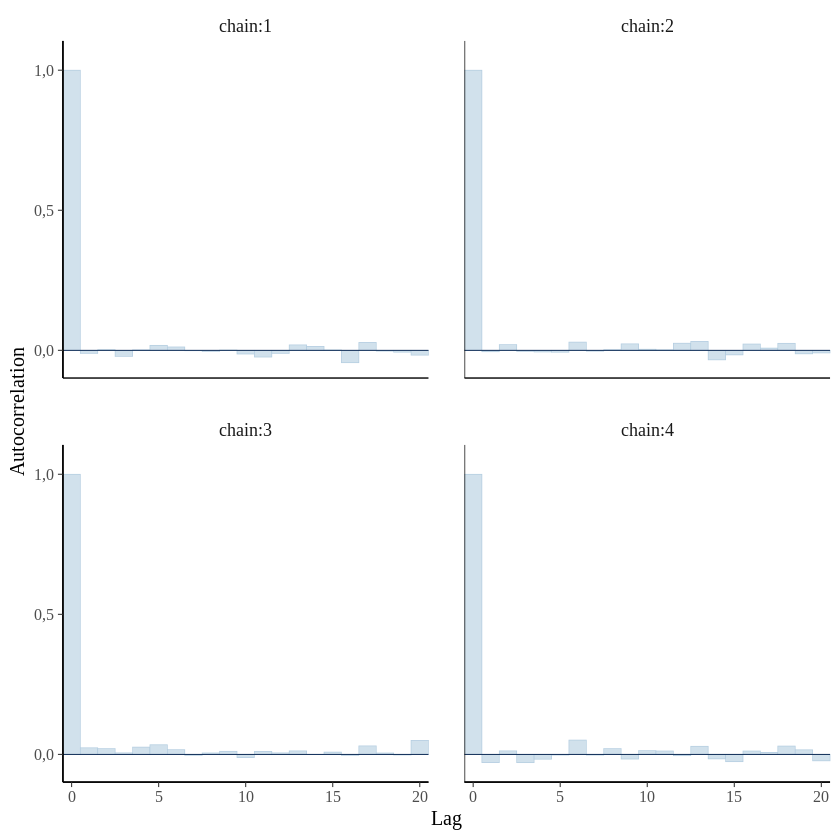

[1] "aes_2012"


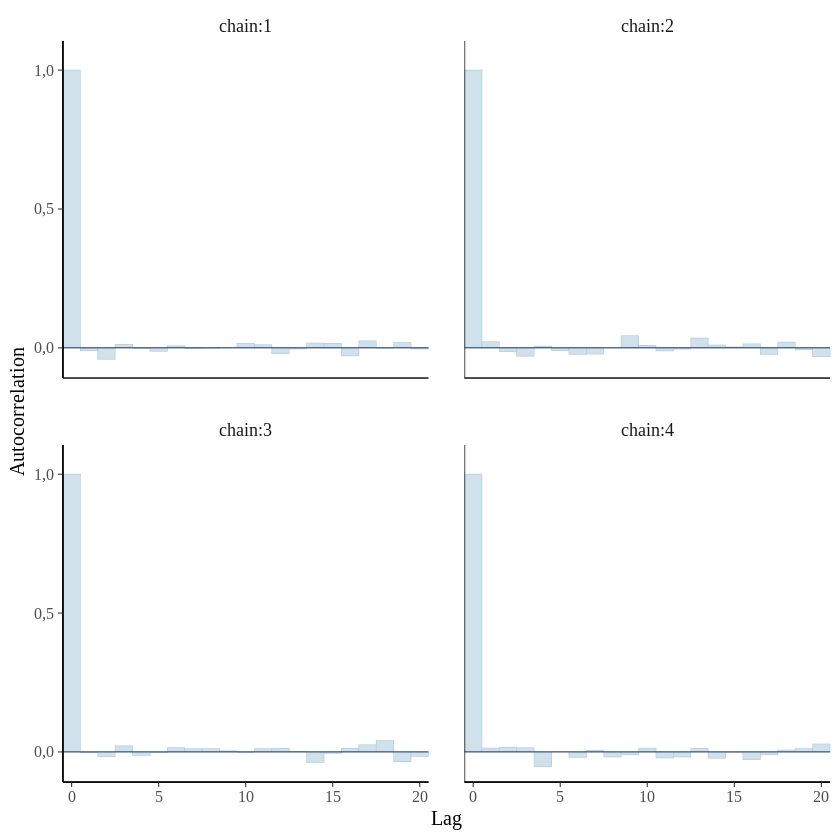

[1] "alt_2012"


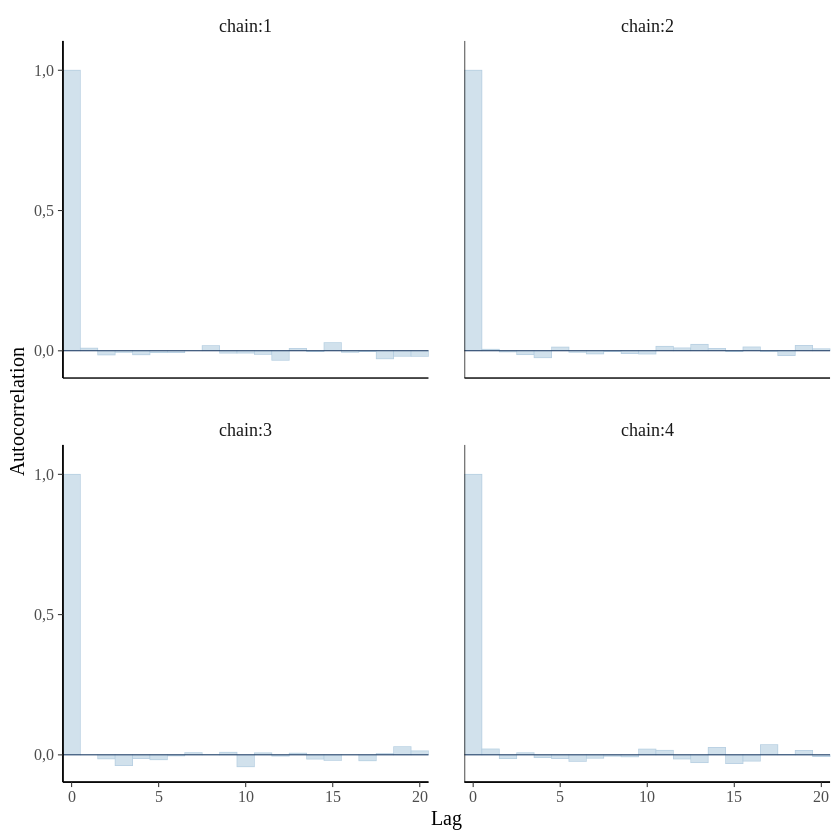

[1] "anx_2012"


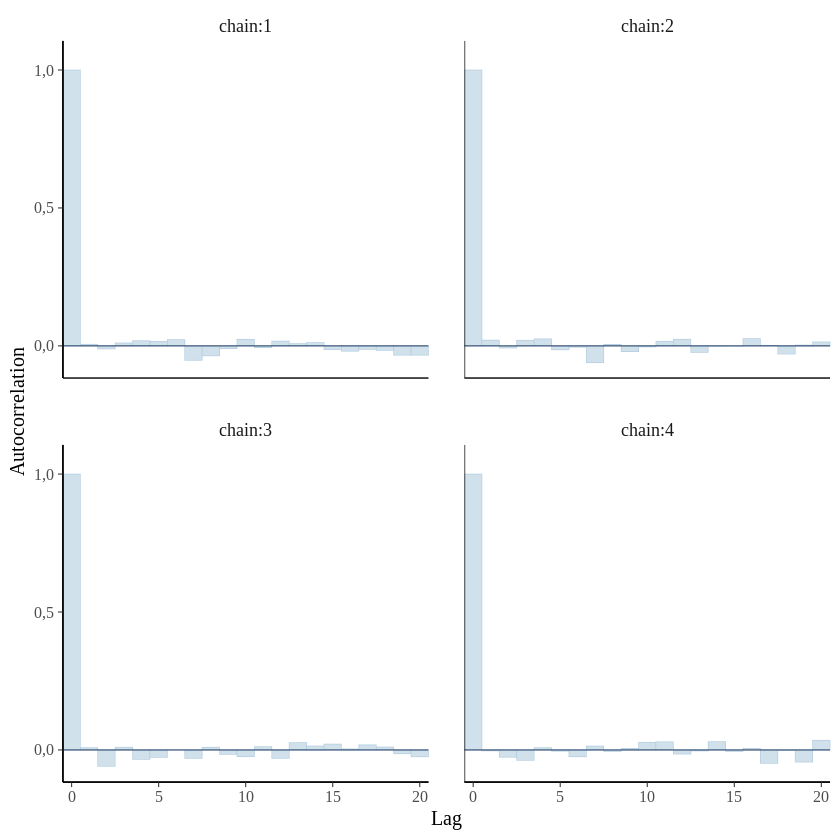

[1] "ass_2012"


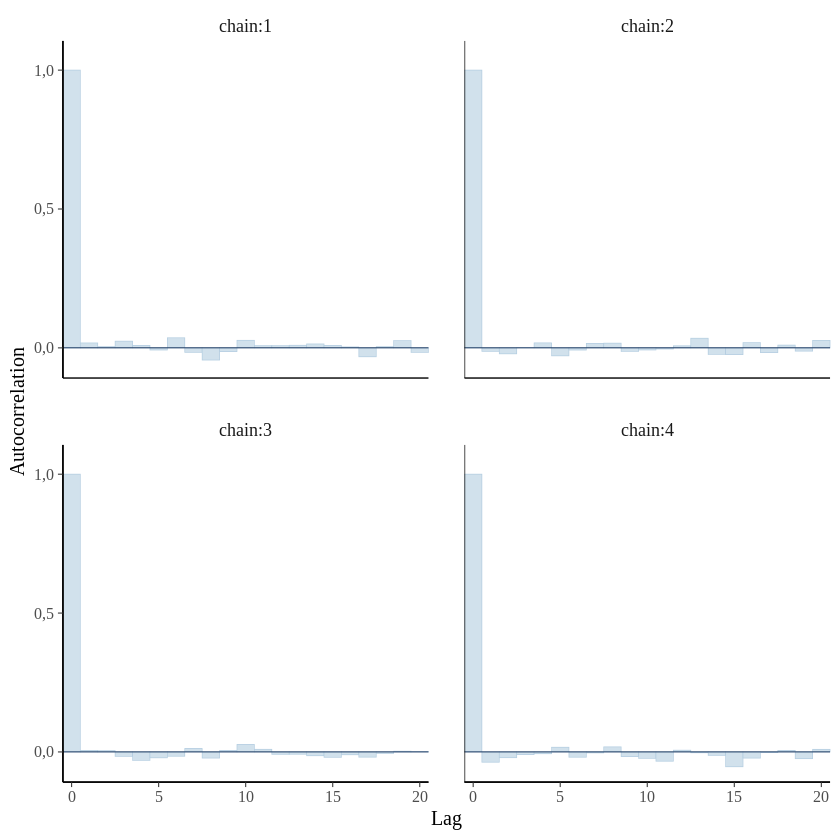

[1] "cmp_2012"


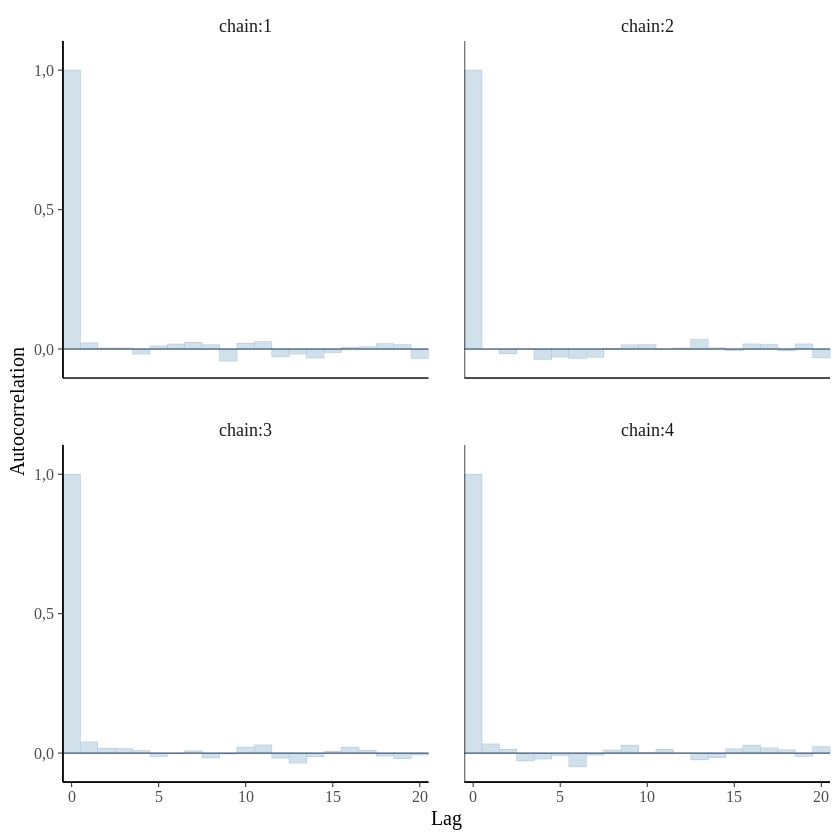

[1] "dep_2012"


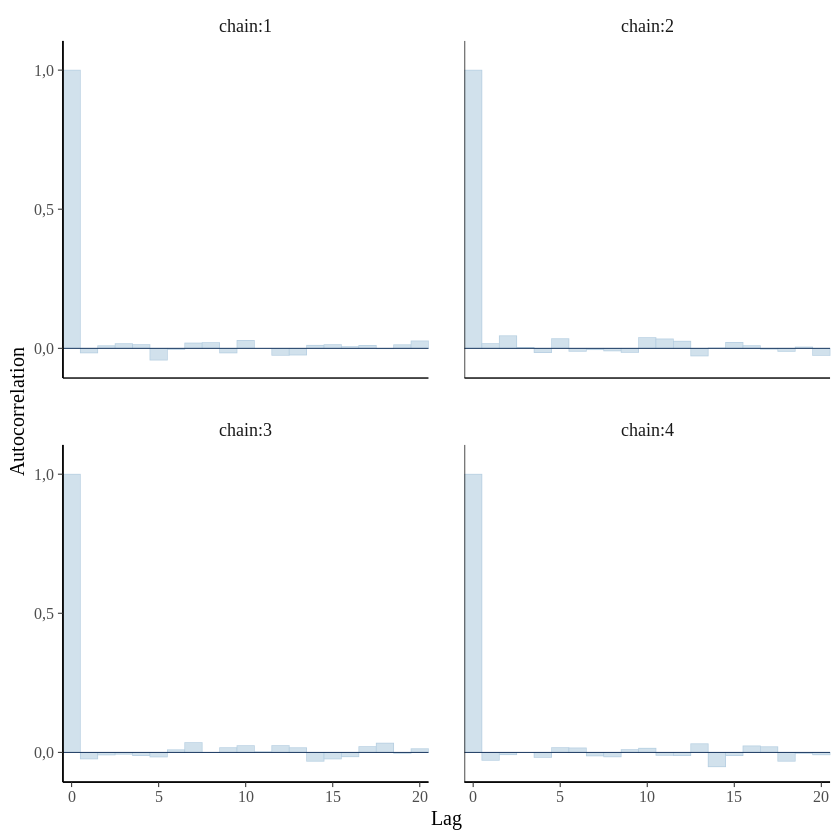

[1] "ids_2012"


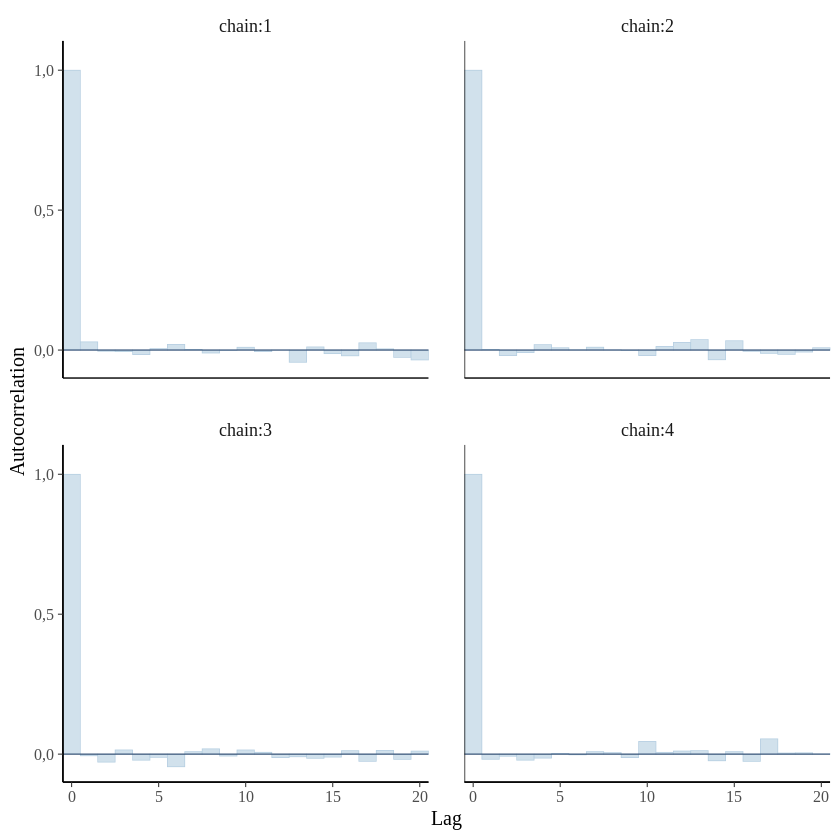

[1] "ord_2012"


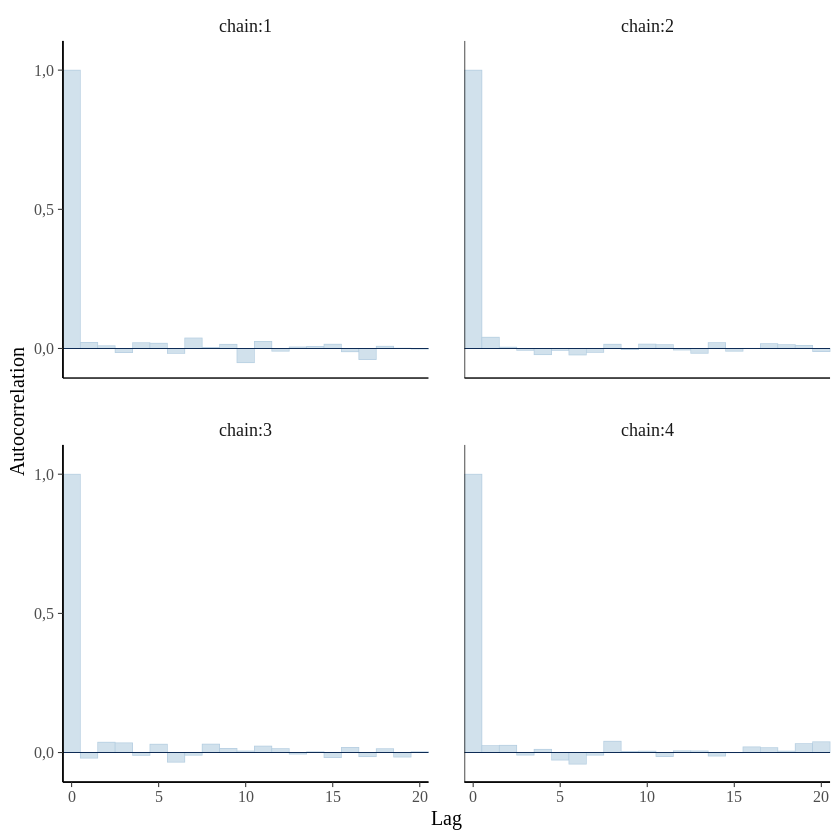

[1] "sfd_2012"


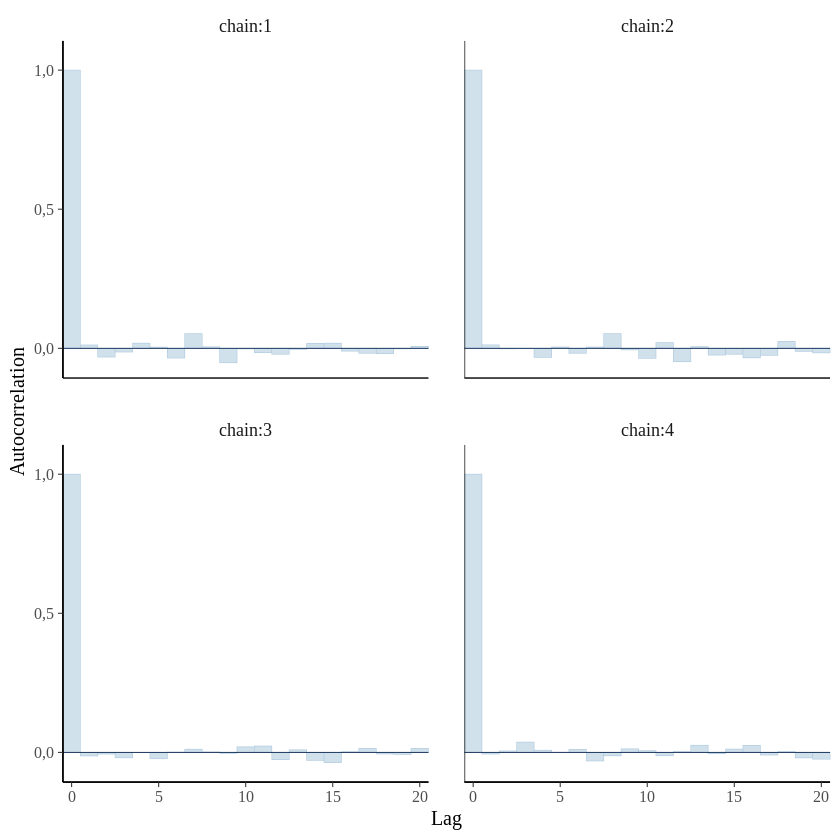

In [112]:
for(i in colnames(posterior[,1,])){
    print(mcmc_acf_bar(posterior[,,i]))                                                                                   
    dev.copy(png, paste('Plots/acf_',i,'.png',sep=''),width=600,height=500,res=100)
    dev.off()
    print(i)
}